# Stocks Analysis

## Introduction
*“Investing is simple, but not easy.” ― Warren Buffett*[^1]  

Investing has never been more accessible, with a rise in the availability of apps on phones and tablets aimed at reducing complexity for buying and selling shares at the convenience of the user. This ease of access has brought with it the next wave of investors with a study by FINRA showing that 21% of investors “have less than two years of experience” a number which nearly matched the amount of investors who had started within the previous 8 years.[^2]  

Easier access has empowered more people to invest, however, it has also introduced new risks: impulsive trading, speculative behaviour, and overexposure to volatile assets. While often lacking the personalised advice typically associated with more traditional forms like guidance from a financial advisor to advise on the best ways to build an portfolio.[^3]   

This project will examine trends across real stock market data from the ``yfinance`` module within Python. Focusing on 4 industries using a collection of data from 12 companies to feed the analysis to provide insights and highlight the complexity of the stock market. Key areas that will be assessed include industry and company trends across different time periods.  The project aims to look at the performance over these areas and see which opportunities may appeal most and to different types of investor.

## Project set-up

In [210]:
# importing libraries and functions from myfunction.py

import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

from myfunctions import company_1_yr_plots, company_close_plots, company_volatility_plots, company_trading_volume_plots, company_cumulative_returns,industry_close_prices_plot, company_stats, create_industry_returns_df


In [211]:
# creating a dictionary to define the industries and the companies that will be used for the project
industries = {
    'Technology': ['AAPL', 'MSFT', 'NVDA'], 
    'Quantum Computing': ['IONQ', 'RGTI', 'QBTS'],
    'Electric Vehicles': ['TSLA', 'RIVN', 'LCID'],
    'Renewable Energy': ['NEE', 'FSLR', 'ENPH']
}

In [212]:
# creating a dictionary to store dataFrames to for different time period
industry_dataframes = {
    '5y': pd.DataFrame(),  # mid-term trends (5 years)
    '1y': pd.DataFrame(),  # quarterly/yearly movements (1 year)
    '10y': pd.DataFrame()  # long-term trends (10 years or max)
}

In [213]:
company_ticker_to_fullname = {
    # Technology
    'AAPL': 'Apple Inc.',
    'MSFT': 'Microsoft Corporation',
    'NVDA': 'NVIDIA Corporation',

    # Quantum Computing
    'IONQ': 'IonQ, Inc.',
    'RGTI': 'Rigetti Computing, Inc.',
    'QBTS': 'D-Wave Quantum Inc.',

    # Electric Vehicles
    'TSLA': 'Tesla, Inc.',
    'RIVN': 'Rivian Automotive, Inc.',
    'LCID': 'Lucid Group, Inc.',

    # Renewable Energy
    'NEE': 'NextEra Energy, Inc.',
    'FSLR': 'First Solar, Inc.',
    'ENPH': 'Enphase Energy, Inc.'
}

### Data Collection and Preparation

Due to the newness of some of the industries being considered for the project, the timeframe the data is available for each of the chosen companies will be checked to see if they have data available for the last 5 years. 

In [214]:
print(f'Company:\tData starts:\tLatest date:\t5yr available?')
print(f'------------------------------------------------------------------')

# checking the start date of the data for the chosen companies
for industry, companies in industries.items():
        for company in companies:
            ticker = yf.Ticker(company)
            hist = ticker.history(period='max')  # fetching the maximum available data
            start_date = hist.index.min().strftime('%Y-%m-%d')  # getting the earliest date available but looking at the min in the index for each company and formating the start date as a string to be shown in so only the date information and not the timestamp are included
            latest_date = hist.index.max().strftime('%Y-%m-%d')
            if pd.to_datetime(start_date) > pd.Timestamp('2019-12-27'):
                five_yr_available = 'No' 
            else: 
                five_yr_available = 'Yes'
            
            print(f"{company}\t\t{start_date}\t{latest_date}\t{five_yr_available}") # printing the company, date the data is available from, latest date information for the data pulled and a yes/no answer of if the data is available for the last 5 years


Company:	Data starts:	Latest date:	5yr available?
------------------------------------------------------------------
AAPL		1980-12-12	2025-01-10	Yes
MSFT		1986-03-13	2025-01-10	Yes
NVDA		1999-01-22	2025-01-10	Yes
IONQ		2021-01-04	2025-01-10	No
RGTI		2021-04-22	2025-01-10	No
QBTS		2020-12-11	2025-01-10	No
TSLA		2010-06-29	2025-01-10	Yes
RIVN		2021-11-10	2025-01-10	No
LCID		2020-09-18	2025-01-10	No
NEE		1973-02-21	2025-01-10	Yes
FSLR		2006-11-17	2025-01-10	Yes
ENPH		2012-03-30	2025-01-10	Yes


From the above it can be seen that there are several companies which do not have 5 years’ worth of data available.  

These are companies belonging to the Quantum Computing and Electric Vehicle industries, which is not surprising as the technology for these industries are relatively new/young in comparison to some of the historical companies/industries in the stock market and there for can only be used for short-term analysis.

In [215]:

# fetching and saving the data for multiple time periods to individual dataframes
for time_period in ['5y', '1y', '10y']:
    temp_data = []  # storing the data temporarily for each time period so it can be added to the dataframe later
    for industry, companies in industries.items():  # fetching the data for each industry by looping through the key value pairs returned from the .items() method
        for company in companies:  # getting the data for each company within the industry specified for the parent for loop
            # fetching the historical data
            # if loop checking the time_period value per iteration and choosing what steps to complete depending on the value 
            if time_period in ['5y', '10y'] and industry in ['Quantum Computing', 'Electric Vehicles']: 
                continue  # skipping fetching 5y and 10y data for the Quantum Computing and Electric Vehicles industries as not all companies have sufficient data for this
            else:
                hist = yf.Ticker(company).history(period=time_period)
            # adding headers and defining which data should be entered for those columns
            hist['Industry'] = industry
            hist['Company'] = company
            hist['Timeframe'] = time_period
            temp_data.append(hist) # adding the details gathered to the temp_data list
    # adding all data for the period into a DataFrame
    industry_dataframes[time_period] = pd.concat(temp_data)

### Checking DataFrames for missing data and the data types of the columns

In [216]:
# lopping through each of the dataframes created to see if any data is missing
for time_period in ['5y', '1y', '10y']: 
    no_of_blanks = industry_dataframes[time_period].isna().sum().sum() # looking for NaN values and getting the total of the sum of missing values for all columns in the df 
    print(f'The {time_period} data contains {no_of_blanks} missing values.') # printing one summary line to state if there is missing values in the dataset
    df_dtypes = industry_dataframes[time_period].dtypes.value_counts()
    print(f'The following data types can be found in the df:\n{df_dtypes}\n')

The 5y data contains 0 missing values.
The following data types can be found in the df:
float64    6
object     3
int64      1
Name: count, dtype: int64

The 1y data contains 0 missing values.
The following data types can be found in the df:
float64    6
object     3
int64      1
Name: count, dtype: int64

The 10y data contains 0 missing values.
The following data types can be found in the df:
float64    6
object     3
int64      1
Name: count, dtype: int64



As calculations and comparitive analysis will be performed later in the project, the 3 columns which are of dtype ``object`` will be checked to ensure these are not numeric columns which have incorrect dtype assigned.  

This is done as a value assigned as an ``object`` will not be possible to be used for performing numerical operations later. 

In [217]:
# checking which columns are of dtype object
print('The columns of dtype object are:\n')
for time_period in ['5y', '1y', '10y']: 
    # Find columns with 'object' data type
    object_cols = industry_dataframes[time_period].select_dtypes(include='object').columns.tolist()
    print(f'{time_period.capitalize()} DataFrame:\n{object_cols}\n')


The columns of dtype object are:

5y DataFrame:
['Industry', 'Company', 'Timeframe']

1y DataFrame:
['Industry', 'Company', 'Timeframe']

10y DataFrame:
['Industry', 'Company', 'Timeframe']



The returned columns, *Industry*, *Company* and *Timeframe*, do not contain numeric values and not needed for calculations. In this case, the ``object`` dtype should cause no issues.

### Checking the index data

As analysis and comparisons on the data over different time periods will be performed, having the index be of ``Pandas`` ``datetime`` index is preferred.

In [218]:
# checking the index dtype for each dataframe
for time_period in ['5y', '1y', '10y']:
    index_dtype = industry_dataframes[time_period].index.dtype
    print(f'The index data type for the {time_period} dataframe is: {index_dtype}')

The index data type for the 5y dataframe is: datetime64[ns, America/New_York]
The index data type for the 1y dataframe is: datetime64[ns, America/New_York]
The index data type for the 10y dataframe is: datetime64[ns, America/New_York]


From the above output it can be seen that the index data is of the datetime64 dtype which is desired. However, additional information is present suggesting the time zone of the data retrieved is America/New York and not UTC.  

To confirm this, one of the index values will be checked as an example to see how the data is showing.

In [219]:
# printing the first value for the index in each df
print(f'The first index value in each index is:')
for time_period in ['5y', '1y', '10y']:
    print(f'{time_period}: {industry_dataframes[time_period].index[0]}')  # First index


The first index value in each index is:
5y: 2020-01-13 00:00:00-05:00
1y: 2024-01-11 00:00:00-05:00
10y: 2015-01-12 00:00:00-05:00


The ending ``-05:00`` confirms that the timestamp is matching the ``ns, America/New_York`` time zone.   

As UTC is typically the standard time zone used worldwide the index will be updated to convert from ``America/New_York`` to ``UTC`` to tidy the data.  

This will also be beneficial to avoid any issues with compatibility should the data want to be reused for analysis for further markets further down the line.

In [220]:
# converting to UTC time and removing the timezone information for each df
for time_period in ['5y', '1y', '10y']:
    industry_dataframes[time_period].index = industry_dataframes[time_period].index.tz_convert('UTC').tz_localize(None) # converting the timestamp from NY time to UTC and removing the information for the offset (+00:00) for better readibility when using the index for plotting 
    print(f'{time_period}: {industry_dataframes[time_period].index[0]}')  # printing the value for the first index of each df to validate that the timezone information is removed


5y: 2020-01-13 05:00:00
1y: 2024-01-11 05:00:00
10y: 2015-01-12 05:00:00


### Setting colours to be used per industry in the plots 

In [221]:
# defining a dictionary mapping industries to colours to maintain consistency in colours used for plots  throughout the project
colours = {
    'Technology': 'royalblue',
    'Quantum Computing': 'orchid',
    'Electric Vehicles': 'green',
    'Renewable Energy': 'orange'
}

colours_comp = {
    'AAPL': 'royalblue',
    'MSFT': 'orchid',
    'NVDA': 'green',
    'IONQ': 'orange',
    'RGTI': 'firebrick',
    'QBTS': 'yellow',
    'TSLA': 'gray',
    'RIVN': 'teal',
    'LCID': 'goldenrod',
    'NEE': 'tomato',
    'FSLR': 'mediumvioletred',
    'ENPH': 'slateblue',
}


## Company Anaylsis

### Short-Term analysis (1-year)

#### Apple Inc. & Microsoft Corporation

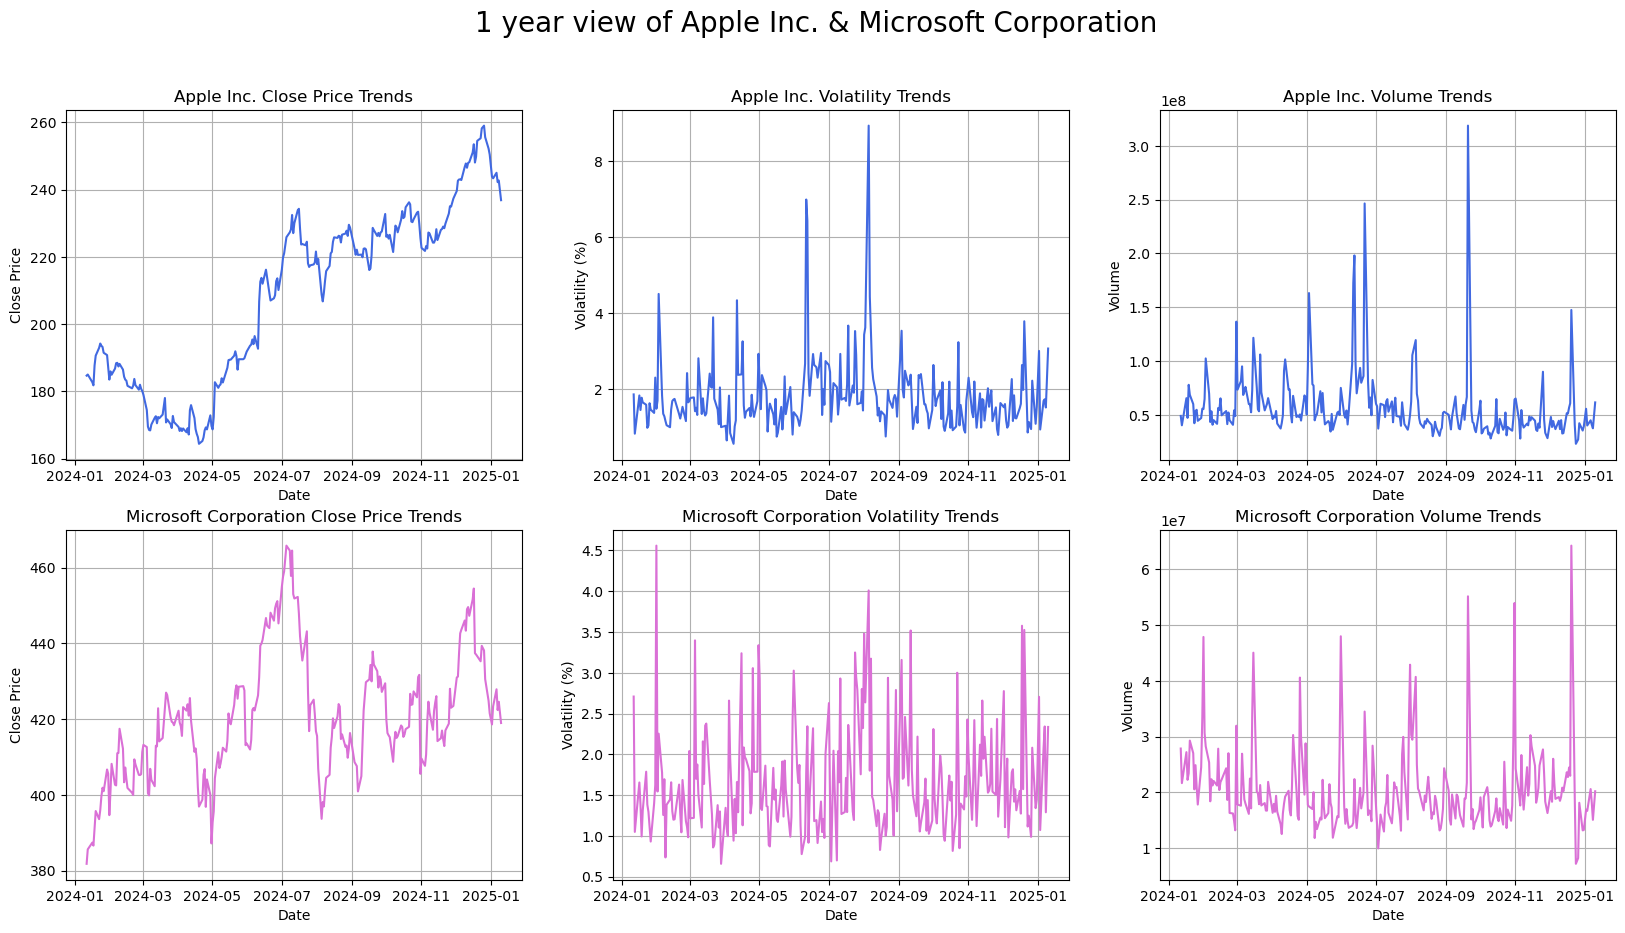

In [222]:
# plotting the results for the Close Price, Volatility and Volume for the chosen companies
technoology_company_plots = company_1_yr_plots(selected_companies=['AAPL','MSFT'], industry='Technology', fullnames=company_ticker_to_fullname, colours=colours_comp, data=industry_dataframes)

**Close Price trends:**  

Starting with close prices for the last year, Apple stocks have a continuous upwards trend. Significant growth can be seen with the year starting with \$184.7 and peaking for the year at \$259.02 on the 26th of December. Coming into 2025, the stock begins to start showing a slight downward trend with a closing price on the 10th of January 2024 of \$236.85.   

Looking at Microsoft in comparison, the year started with a Close Price of \$381.78 and continues with a more volatile and range-bound price trend compared to Apple. It can also be seen that after the max price of \$465.79 is reached on 5th of July there is a visible decline. In December, another peak of\$454.46 is seen on the 17th of December which then begins to slope downwards from this date and into 2025. Coming in at\$418.95 on the 10th of January 2025.   

**Volatility trends:**  

For Apple there are two distinct spikes for the volatility throughout the year. Reaching the maximum volatility recorded on the 5th of August with 8.93%. June has the next highest peak for Volatility with 6.99%. The remainder of the year has shown a much smaller range of volatility with the max typically only reaching around 3%.  

For the majority of the year, Microsoft’s volatility stays between 1% and 3% as shown in the above plot. The peak volatility for the year occurred early on in 2024 on the 31st of January, at 4.56%.    

**Volume Trends:**   

For the typical month of Apple stocks, it seems that the trading volume stays around the 50-100 million range looking at the plot. The largest spike in the volume trends can be seen on the 20th of September 2024 with an amount of 318 million seen. The next highest volume amount occurred in June on the 21st with an amount of 246 million. Taking the spikes for the Volatility for Apple for 2024 into account it seems there be a link, with high volume seemingly aligned with an increase in the price volatility.   

For Microsoft the trading volume ranged between 10-30 million shares. A max is reached of 64 million on the 20th of December 2024. Before this the highest peak for the year was on the 20th of September with 55 million. While there are a number of noticeable peaks for Microsoft for the year these are much smaller than the spikes for Apple shares. Looking at the year overall for Microsoft, the volume trend appears more consistent to that of Apple’s shares. 

**Overall Summary:**   

For 2024 Apple demonstrated stronger growth but with higher volatility and more dramatic changes in trading volume. In comparison Microsoft showed a smaller range of volatility for the year with modest growth and consistent market behaviour. If looking to invest Apple’s shares may appeal to a more risk-tolerant investor due to the higher volatility while Microsoft’s stability may be more likely to attract a more conservative investor.


#### IonQ, Inc & D-Wave Quantum Inc.

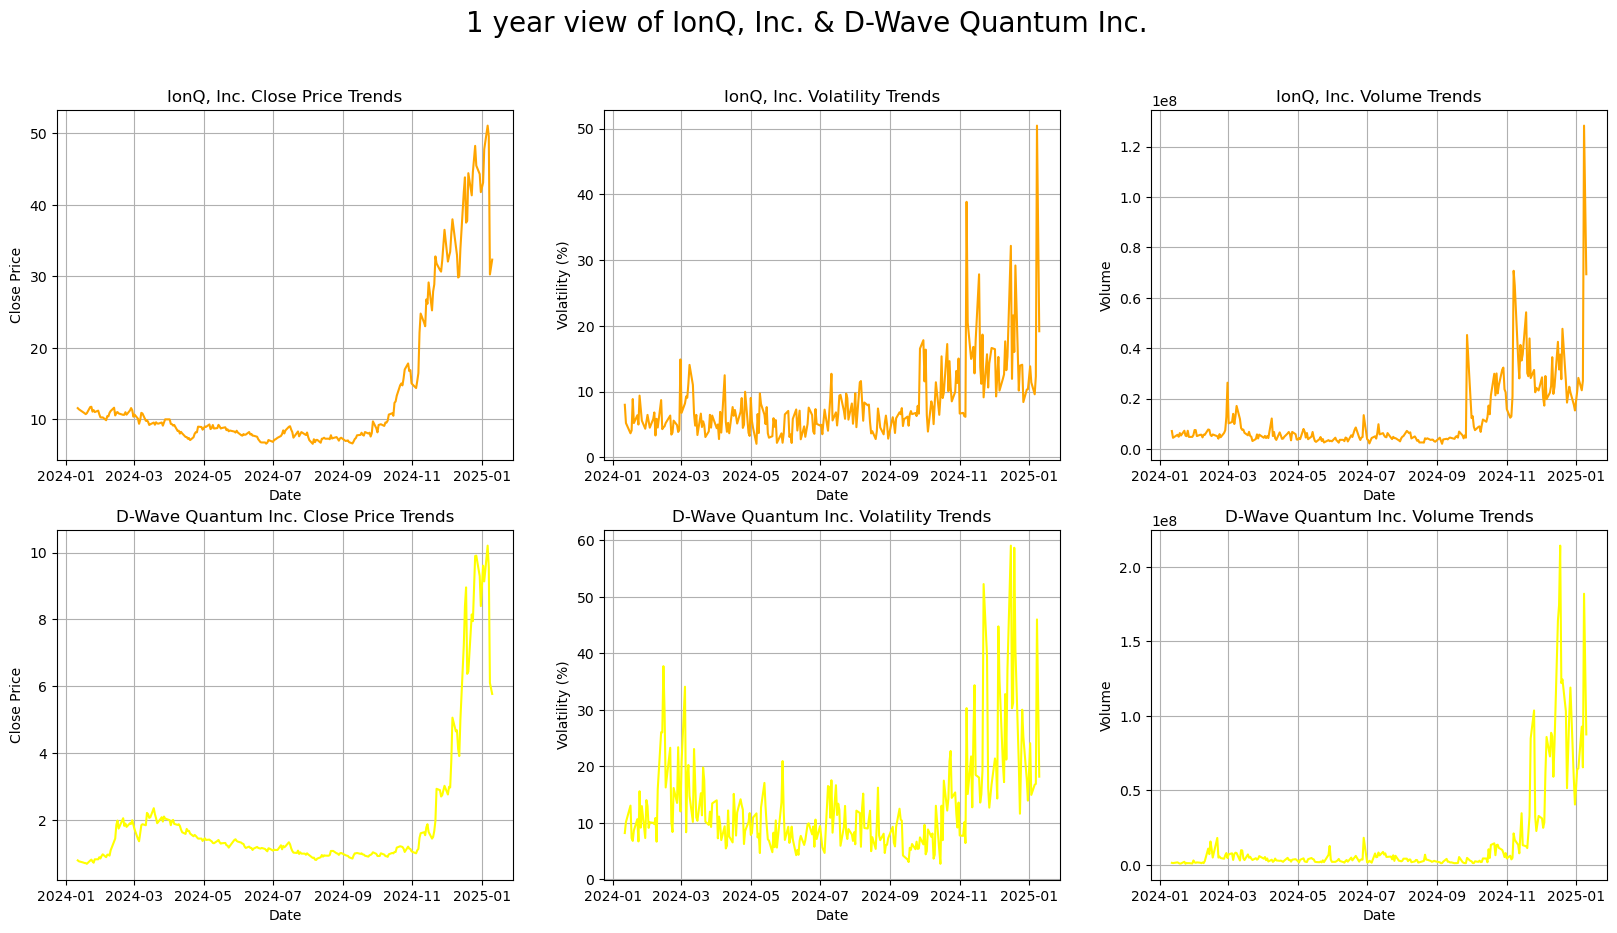

In [223]:
quantum_company_plots = company_1_yr_plots(selected_companies=['IONQ','QBTS'], industry='Quantum Computing', fullnames=company_ticker_to_fullname, colours=colours_comp, data=industry_dataframes)


**Close Price Trends:**  

For IonQ, 2024 started off with a relatively flat declining trend from January to September 2024, with a minimum closing price for the year recorded on the 5th of August at\$6.47 per share. Starting from October 2024, a steep upward trend can then be seen, with the close price swiftly rising from \$10 to the highest close price for 2024 on the 26th of December of \$48.24.  Beginning of 2025 this step upwards trend has s sharp drop-off, going from close to \$50 per share to \$32.33.

D-Wave starts off the year with the minimum close price for 2024 being recorded early in the year on the 19th of January of \$0.69. The close price reaching 2.35 on 18th of March before slowly sloping downwards until November 2024. From November onwards a massive surge can be seen with the value rising from under \$2 to \$9.91 per share by the 27th of December. 2025 starts off strong with \$10.21 per share recorded on the 6th of January 2025 before swiftly dropping almost to half that price 4 days later with \$5.77 recorded on the 10th of January 2025

**Volume Trends:** 

2024 starts low and steady for the volume trends for IonQ until October 2024. November and December then show significant spikes in the volume trends peaking at over 70 million on the 7th of November 2024. There is a large drop-off beginning of 2025 with a minimum volume of 22 million recorded on the 2nd of January before rising again to 128 million on the 8th of January. The spike in volume trends appears to align with spikes in close price and volatility experienced end of 2024 and start of 2025

For D-Wave the first half of the year has minimal trading volume recoded, with the minimum value being recorded on the 23rd of January 2024 at 768 thousand. From November onwards a large growth in volume it apparent with the maximum recorded on the 18th of December with 214 million. For D-Wave, it can also be observed that the spikes in volume trends coincide with the price and volatility increases, indicating strong speculative trading.

**Volatility Trends:**

Volatility for IonQ stays relatively stable under 10% during the first half of the year. From September onwards a slight upwards slant can be seen in the plot as the volatility increases. With the volatility reaching up to 50% in January 2025. The higher volatility coincides with the surge in close price which starts at the end of 2024. 

For D-Wave there is a higher baseline for the volatility throughout the year, with the volatility often reaching above 10%. The last quarter of 2024 shows the most drastic growth in volatility with spikes almost reaching 60% volatility in December 2024. When looking at the IonQ and D-Wave plots, there is more frequent fluctuation in volatility for D-Wave. 

**Overall Summary:**

IonQ can be seen going from a steady flat trend to explosive growth with relatively controlled volatility until it’s breakout in Q 2024. In contrast, D-Wave showed higher volatility overall for 2024 with a more abrupt price surge late in the year.

With this, IonQ’s performance would more likely appeal to growth investors seeking momentum, while D-Wave’s volatility might attract more risk-tolerant traders. Overall, for the quantum computing industry, Q4 2024 from both plots suggest that the sector as a whole may have gained momentum which may be liked to industry developments or market trends. 




#### Tesla, Inc & Rivian Automative, Inc

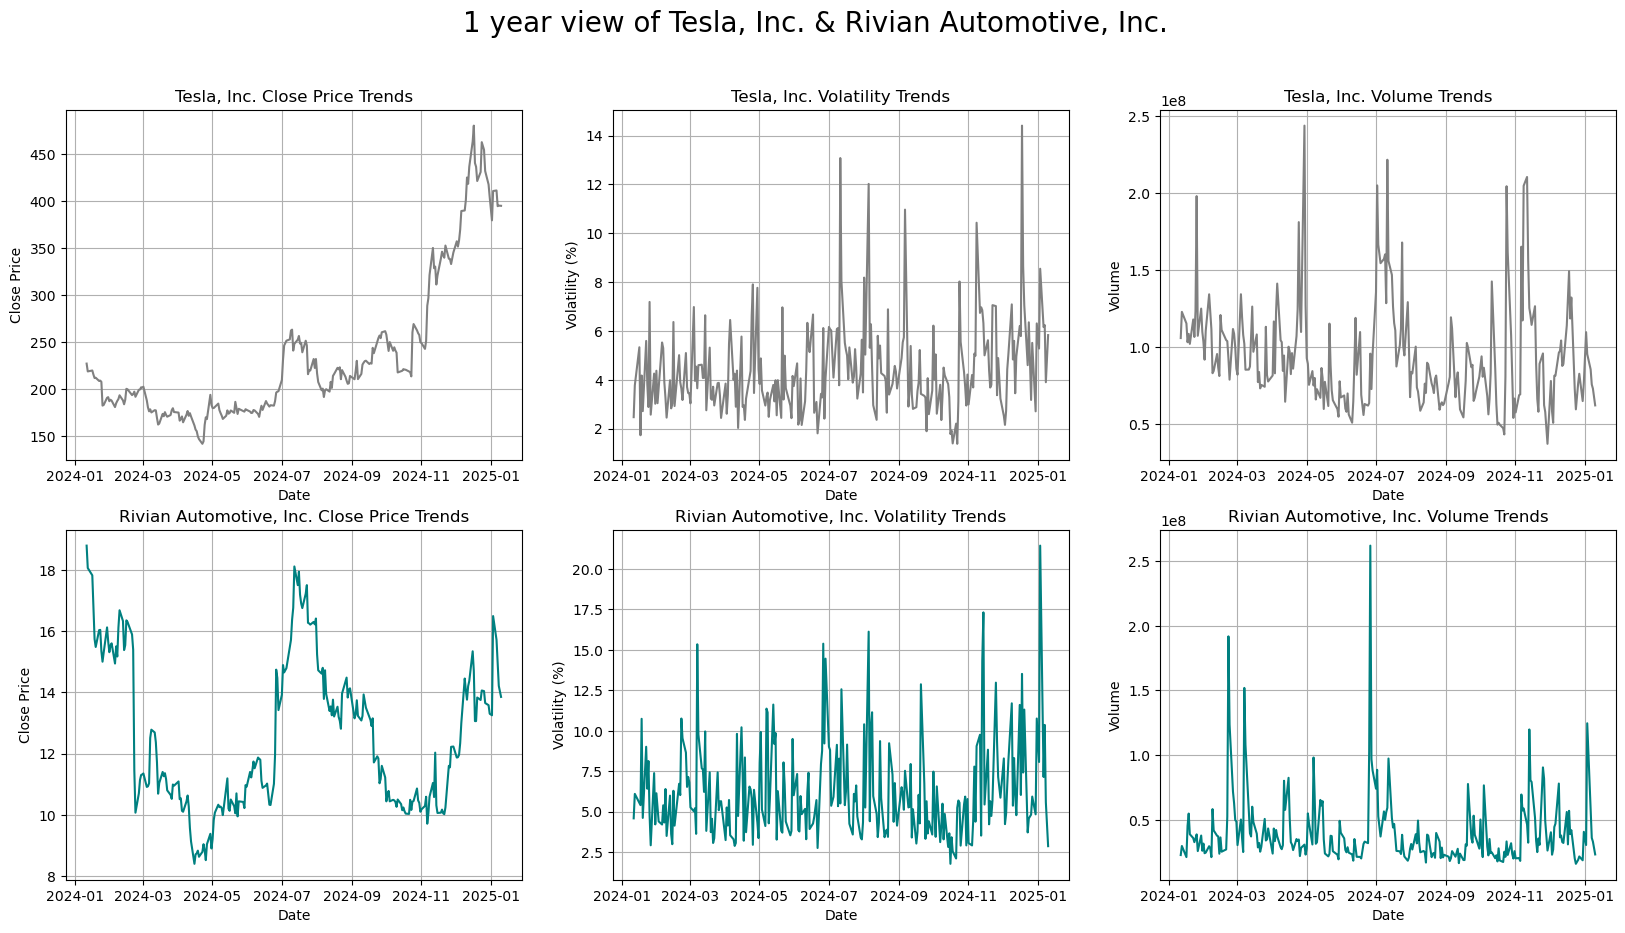

In [224]:
electric_vehicles_company_plots = company_1_yr_plots(selected_companies=['TSLA','RIVN'], industry='Electric Vehicles', fullnames=company_ticker_to_fullname, colours=colours_comp, data=industry_dataframes)

**Close Price Trends:**  

From the plot above 2024 appears to have started on a slight decline for the Tesla stock with the price fluctuating between \$227.22 and \$142.05 (minimum for 2024) until July. From August onwards a strong upward trend begins with the price reaching \$479.86 on 17th of December. Heading into 2025 a slight pullback can be seen with the share dropping under the \$400 mark again, hitting a low of \$379.28 on the 2nd of January 2025. 

Rivian also started 2024 on a declining trend until June 2024, dropping to \$8.40 per share on the 15th of April before steadily rising to the maximum close price of \$18.11 on the 12th of July. Following this a downwards trend is then seen until November 2024 with the stock finishing the year at \$13.3 and reaching as high as \$16.49 per share on the 3rd of January 2025. 

**Volatility Trends:**

For Tesla moderate volatility is experienced throughout the year, ranging between 2% and 6%. Looking at the plot noticeable spikes in volatility can be seen in June, September and December, with the maximum amount of 14.41% recorded for the volatility on the 18th of December 2024. It seems the spikes in the volatility in the later stages of the year may have some relationship to the rising close price trends as some of the significant spikes in the close price occur around a period of heightened volatility. The volatility may be driven by company news or market events. 

Throughout 2024 Rivian appears to display consistently higher volatility than Tesla, with more spikes frequently reaching between 10% -15%. The minimum volatility was recorded on the 16th of October at 1.78%. With one month the maximum volatility was then recorded 14th of November, at 17.32%. 2025 starts with the most significant volatility spike of 21.44% on 3rd of January.  

**Volume Trends:**  

Trading volume for Tesla fluctuated throughout 2024, typically ranging between 50 million – 150 million shares. On the plot a number of significant spikes can be seen for the volume with the maximum volume recorded on the 29th of April with 243 million recorded. There is a downward trend until July with the next highest volume recorded at 221 million on the 11th of July 2024. After this the range continues to fluctuate with two spikes around November reaching over 200 million. These spikes seem to have a relation to the heightened volatility and periods of price growth.  

Trading volume for Rivian was relatively low for most of the year in comparison, with the volume typically under the 50 million threshold. The first spike in volume occurred 22nd of February at 191 million. The largest spike for the year occurred on the 26th of June with 261 million. From here there is a steep decline with the volume fluctuating for the remainder of the year hitting the minimum for the year of 15 million on the 24th of December 2024. Rising again beginning of January to 124 million on the 3rd of January 2025 before plummeting to 23 million 10th of January.   

 **Overall Summary**

Overall, for 2024 Tesla displayed stronger growth and more stable conditions while Rivian faced greater volatility and didn’t have the same sustained growth throughout the year. With this, it is likely that investors seeking steady momentum would be more attracted to Tesla shares for long-term investors. While the volatility of Rivian may be appealing to short-term traders looking for a high-risk high-reward investment.




#### NextEra Energy, Inc & First Solar, Inc.

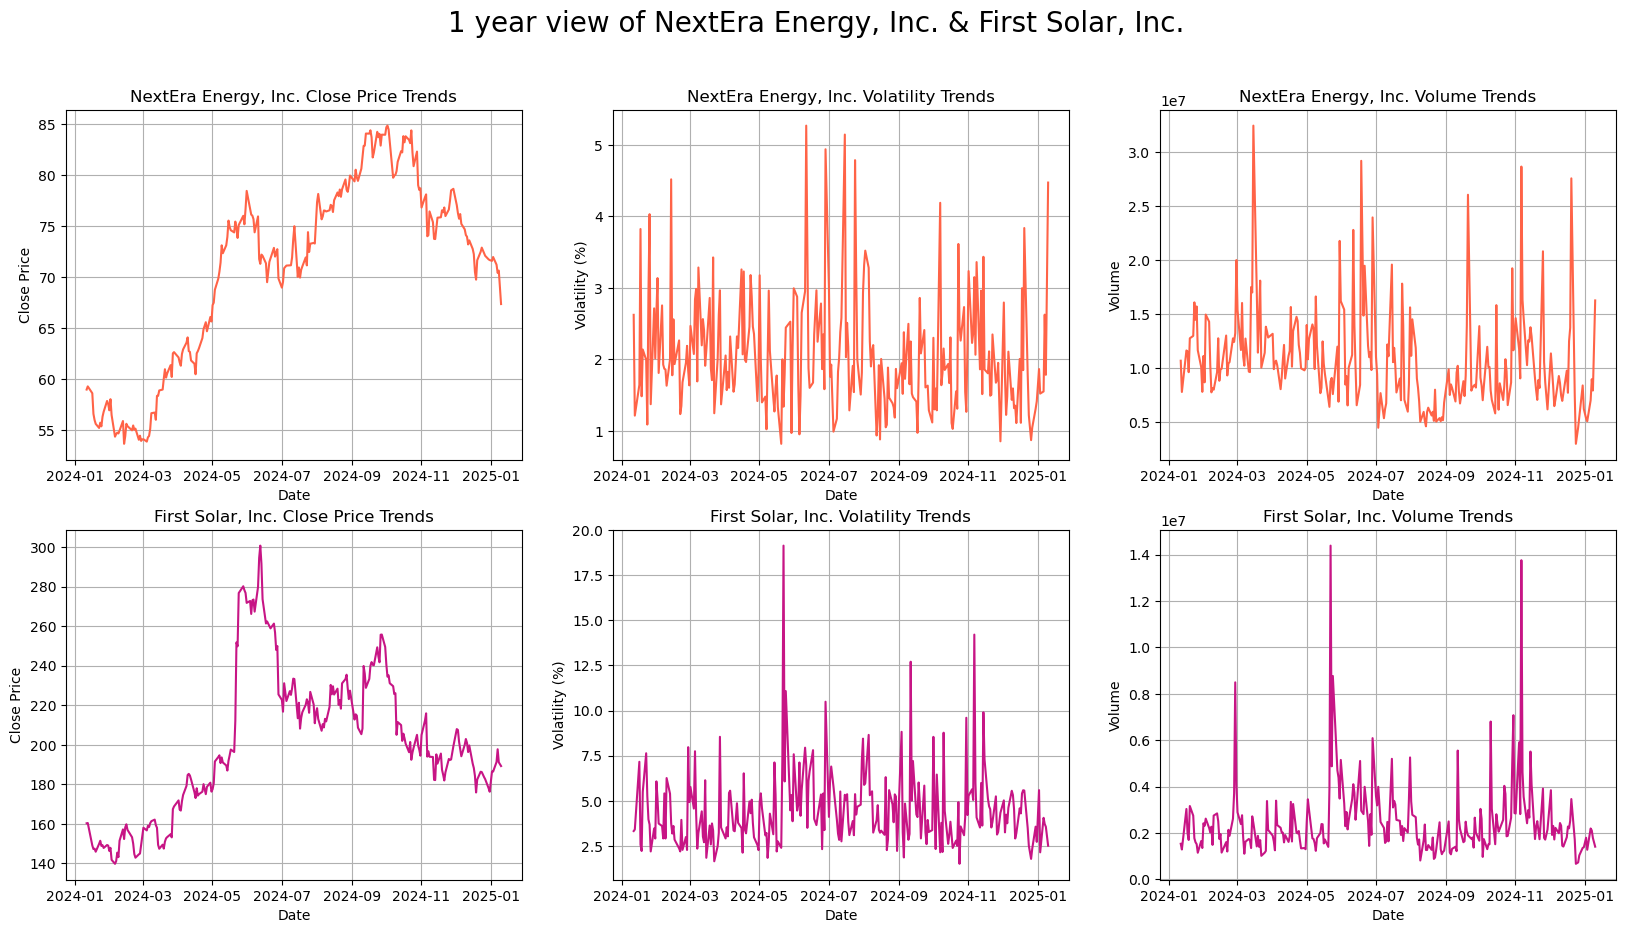

In [225]:
renewable_energy_company_plots = company_1_yr_plots(selected_companies=['NEE','FSLR'], industry='Renewable Energy', fullnames=company_ticker_to_fullname, colours=colours_comp, data=industry_dataframes)

 **Close Price Trends:**

2024 started off for NextEra on a downward trend hitting the minimum close price recorded at \$53.69 on the 13th of February 2024. From February on there is a gradual upward trend until the maximum close price value is reached on the 2nd of October at \$84.86. There is some mild fluctuation along the way between May and September 2024, suggesting there may have been moderate volatility during the growth period. After November, a downward trend can be seen with 2025 starting with a Close price of \$71.61 and continuing in a downward fashion with \$67.38 recorded on the 10th of January 2025.

For First Solar, 2024 started with \$160.29 per share fluctuating until May when a significant spike can be seen with the price going from under \$200 per share to \$300.71 recorded on the 12th of June. After this there is a sharp correction in June 2024 bringing the price back to around \$220. From here the close price fluctuates until the end of the year in a downward trend, with 2025 starting off with \$186.47 per share.

 **Volatility Trends:**

First Solar appears to have relatively low and quite stable volatility for the year, mostly sticking between 1% and 3 % for the year. The largest spikes in volatility can be seen in June with the maximum volatility recorded on the 11th of June at 5.27%. A similar but slightly smaller spike can be seen in July with 5.14% recorded. This consistent pattern for the volatility would suggest that investors are confident in the company. 

In comparison First Solar appears to have a higher volatility throughout the year often hitting between the 5% and 10% range. A distinct spike can be seen in May with volatility reaching as high as 19.14%, aligning with the peak close price seen. The continual volatility fluctuations reflect a sensitive market and may indicate speculative trading. From November onwards there appears to be more stability reflected with 2025 starting off with 5.58% recorded for volatility on the 2nd of January. 

 **Volume Trends:**

The volume trends for the year appear moderately stable, fluctuating primarily between 10 and 15 million. Throughout the year there are occasional spike with the first and largest spike recorded on the 15th of March at 32 million shares. The fluctuation continues throughout the year with notable peaks occurring within June (at 29 million shares) and December (at 27 million shares).

Overall, there is generally a lower trading volume recorded for First Solar with the trading volume ranging between 2 million 6 million shares. Two significant sharp spikes in volume can been in May (14 million shares) and November (13 million shares), these two spikes appear to coincide with periods of high volatility and fluctuation in price. 

 **Overall Summary**

The steady growth and low volatility shown in the NextEra Energy plots, indicate a more stable investment for long-term investors. 
First Solar in comparison experienced strong but volatile growth, with a rapid price increase mid-year with a swift correction in price followed by a fluctuating and downward trend. The rapid price increase makes this a more suitable investment for risk-tolerant investors. 




### Mid-term analysis (5-years)

#### Apple Inc. & Microsoft Corporation

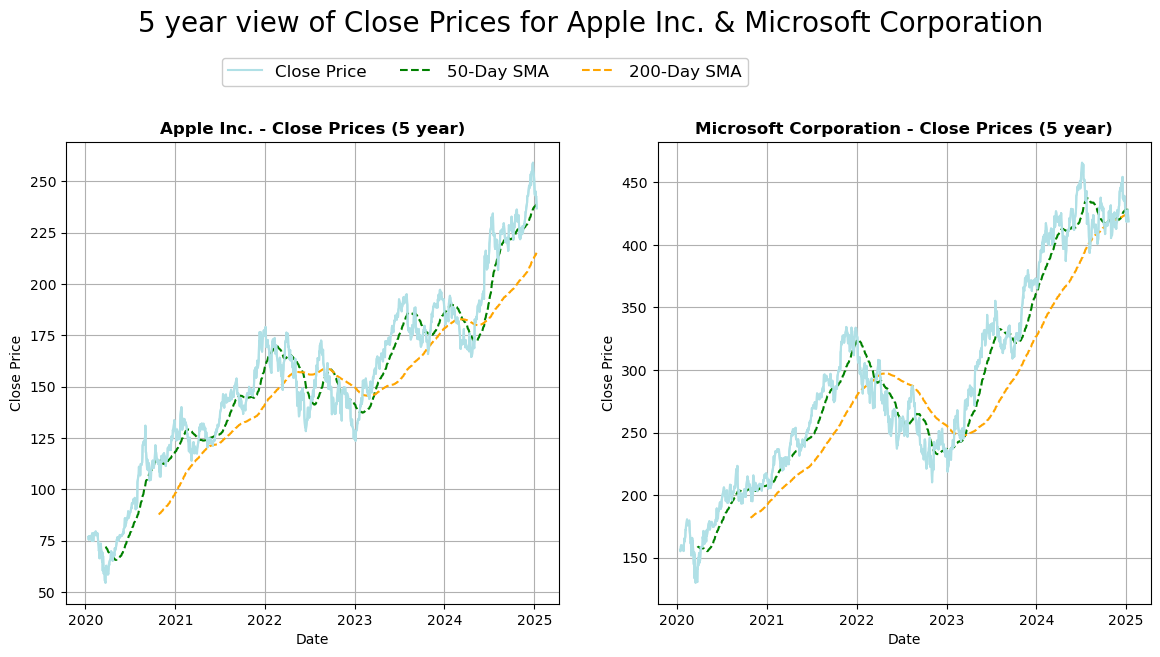

In [226]:
tech_mid_term_volatility= company_close_plots(selected_companies=['AAPL','MSFT'], timeframe='5y', fullnames=company_ticker_to_fullname, data=industry_dataframes)

**Close Price Trends:**  

Consistent growth can be seen from the steady upward trend over the five years for Apple. Starting at around \$75 in 2020 and rising to over \$250 by 2024. A slight declines in 2021 can be seen and a larger dip in 2022, however, Apple quickly recovered and strong growth seen throughout 2023 and 2024. This consistent recovery highlights Apple’s resilience and strong market confidence.
Microsoft also experienced significant growth this was partnered with greater volatility. Starting at around \$150 in 2020, the stock climbed to over \$450 by late 2024. This growth was followed by a sharp decline from 2022 to early 2023. 

**50-Day Simple Moving Average (SMA):**  

The 50-Day SMA for Apple closely follows its price growth, briefly dipping in periods of downturn but showing quick recovery. An example of this quick recovery can be seen between 2023 to 2024, with a steep upward trend following the early 2023 dip and continuing to grow to reach the max value of \$259.02 by end of 2024.
Microsoft’s 50-Day SMA shows more volatility, with the 50-Day SMA remaining below the 200-Day SMA from early 2022 to early 2023, suggesting periods of bearish market. This is followed however by a strong recovery and steep upwards trend until late 2024 where growth appears to flatten.

**200-Day Simple Moving Average (SMA):**  

Apple’s 200-Day SMA manages to maintain steady increase over the five years. The overall rise of the 200-Day SMA may suggest that investors were still confident in their shares regardless of the dip in close prices. The widening gap between the 50-Day and 200-Day SMA in 2023 to 2024 further reinforces the strength of Apple’s bullish market.
In comparison to the 200-Day SMA seen for Apple, the pattern for Microsoft’s 200-Day SMA does not appear to be as stable. Overall, it is generally trending upwards, starting under the \$200 close prices range and reaching around the \$425 mark, it experienced noticeable slight decline during 2022 to 2023, in line with the volatility seen for the close prices at this time.

**Overall**  

Investors looking to avoid high risk instead wanting stable, long-term returns may be attracted by the steady growth visible from the Apple plot. 
For investors happy to invest in stock with short-term risk with potentially higher long-terms rewards Microsoft with greater volatility may be a better fit.

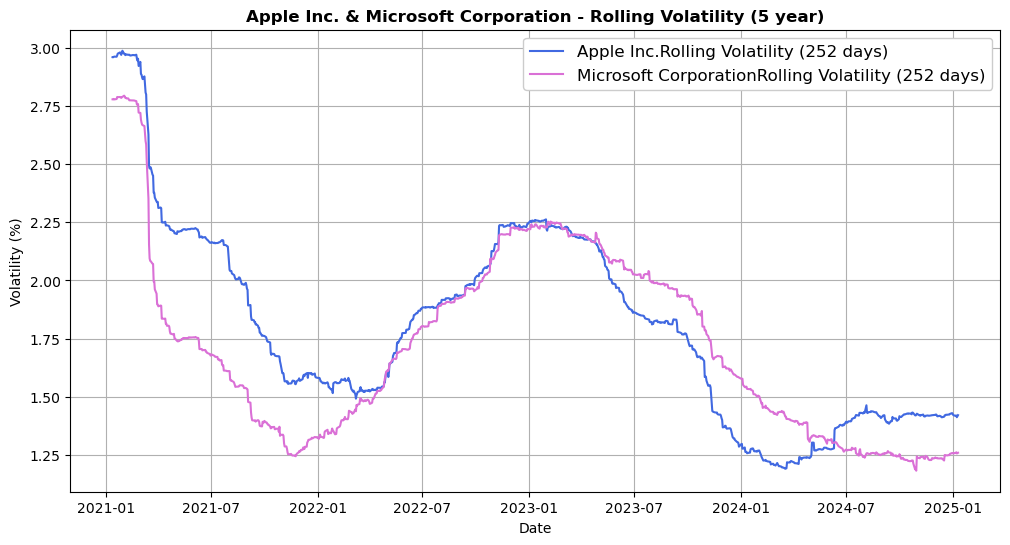

In [227]:
tech_mid_term_volatility= company_volatility_plots(selected_companies=['AAPL','MSFT'], timeframe='5y',fullnames=company_ticker_to_fullname, data=industry_dataframes, colours=colours_comp, rolling_window=252)

**Rolling Volatility** 

Looking at the plot above both companies follow a very similar trend, starting off with elevated volatility in early 2021, potentially due to the post-pandemic market or uncertainties in the economy. 

An upwards trend in the volatility can be seen continuing to a peak in volatility at the beginning of 2023. With both companies being closely aligned in this upwards trend it may suggest that there was broader industry-wide volatility in the market at this time.  

The high volatility steadily declines for both companies throughout 2023 and when it comes to 2024 there is significantly less volatility seen. 

Looking at end of 2024 to 2025 both companies appear more stable with Apple showing higher rolling volatility. 

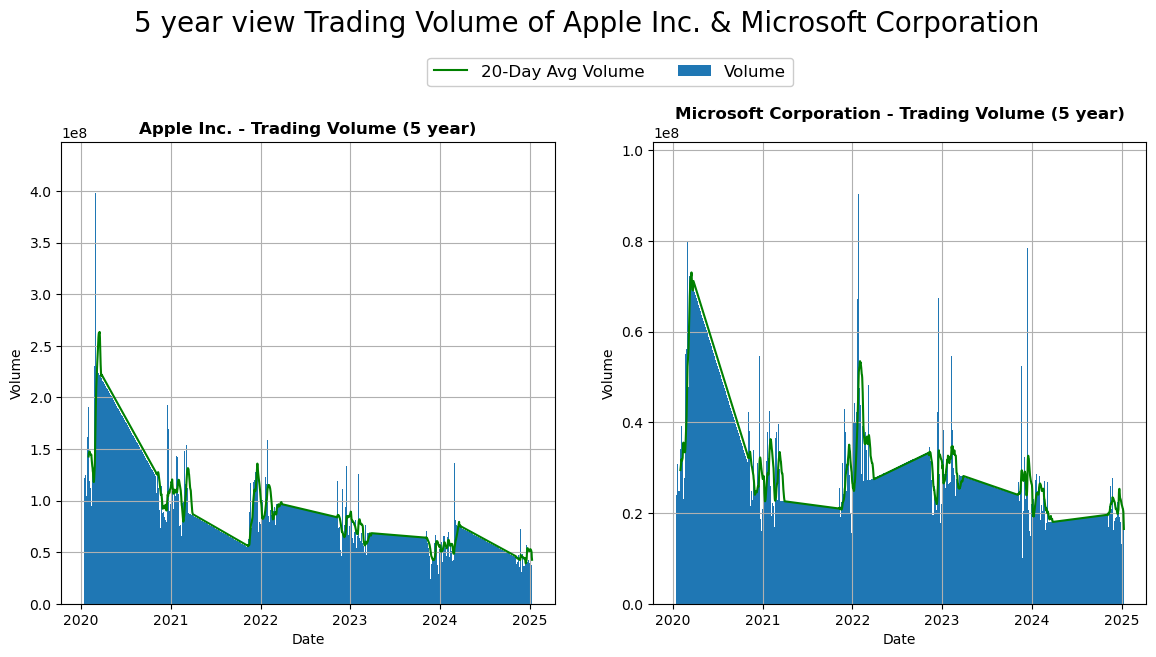

In [228]:
tech_mid_term_trading_volume = company_trading_volume_plots(selected_companies=['AAPL','MSFT'], timeframe='5y', fullnames=company_ticker_to_fullname, data=industry_dataframes)

**Trading Volume** 

When comparing Apple and Microsoft in terms of trading volume over the 5-year interval there are a few observations to note. 

Both companies display a similar downward trend in trading volume starting off highest in 2020 and gradually lowering in volume until 2025. Between 2020 and 2025 Apple and Microsoft display spike in volume, however, the spikes for Microsoft are much larger than that experienced by Apple.  

The smaller spikes in trading volume for Apple may indicate that there are more long-term investors holding onto stock with less speculative trading occurring. This would contribute to the steady decline in volume with less drastic spikes.
On the other hand, the more drastic and frequent spikes in Microsoft could indicate more short-term traders or speculative trading occurring.

One of the causes for the downward trend in trading volume may also be the lower volatility for both companies that is seen from 2020 to 2025 which can be seen in the previous rolling volatility line plot, which could indicate reduced market volatility in the tech industry overall. 

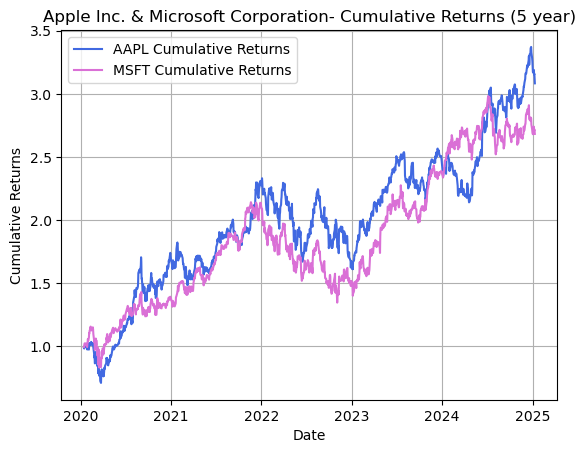

In [229]:
tech_mid_term_cumulative_returns = company_cumulative_returns(selected_companies=['AAPL','MSFT'], timeframe='5y',fullnames=company_ticker_to_fullname, colours=colours_comp, data=industry_dataframes)

**Cumulative Returns** 

Looking at the results of the plot generated for the cumulative returns of Apple and Microsoft for the 5-year period both companies show a primarily upward trend in their returns. 

Over the 5 years it can be seen that Apple has higher cumulative returns in comparison to Microsoft. Up until 2023 both companies appear to perform similarly, and their cumulative returns are much more closely aligned. After this Apple has a stronger upwards growth trend from 2023 to 2024 causing a gap between the two companies in performance.


#### NextEra Energy, Inc. & First Solar, Inc.

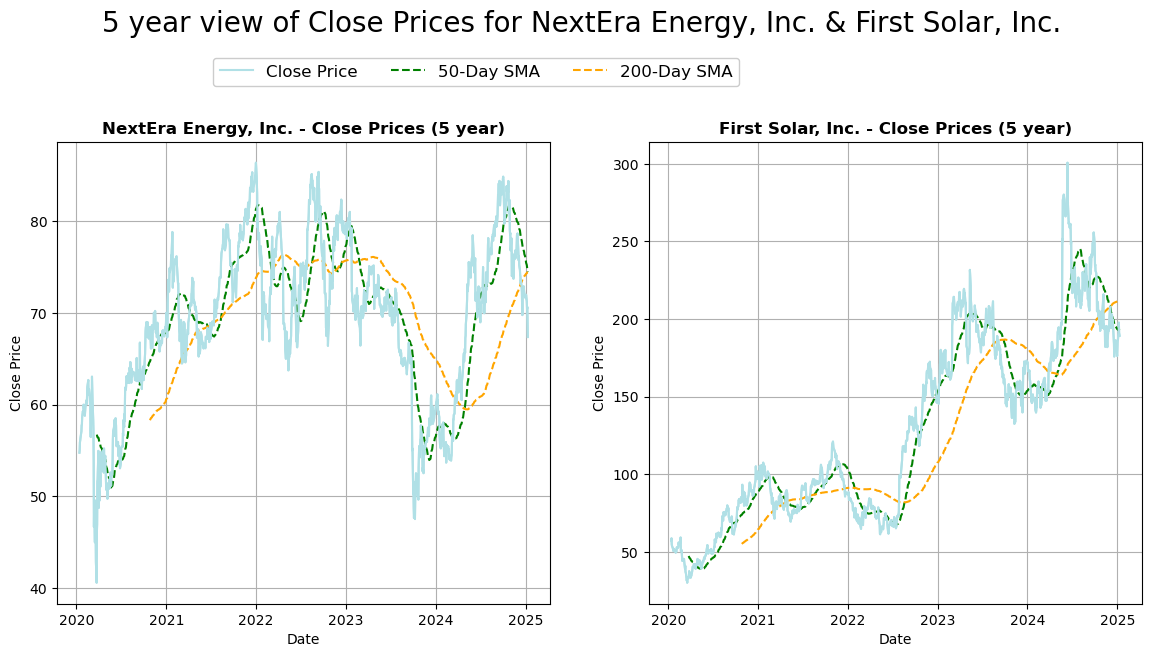

In [230]:
renew_energy_mid_term_volatility= company_close_plots(selected_companies=['NEE','FSLR'], timeframe='5y',fullnames=company_ticker_to_fullname, data=industry_dataframes)

**Close Price Trends:**  

While First Solar demonstrates a larger growth of close price, the NextEra Energy plot shows a steadier upward trend going from a minimum close price value of \$40.59 in early 2020 rising to over \$85 by the start of 2022. The upward trend flattens at this point with only one notable dip in the close price from 2023 to 2024 with the close price reaching lower that \$50 before recovering throughout 2024 to return to \$85 before end of 2024. 
Drastic rapid growth can be seen for the First Solar close prices going from as low as \$30 in 2020 to over \$300 by June 2024. This steep upward trend is then followed by a slight decline to a close price of under \$200 by 2025.

**50-Day Simple Moving Average (SMA):**  

The 50-Day SMA average for NextEra closely tracks the gradual growth of the close price over the 5 years with minimal volatility, with some gradual crossover with the 200-Day line suggesting lower volatility.
A similar crossover of the 50-Day SMA can be seen crossing the 200-Day SMA. The main difference between the pattern of crossovers of the two companies is that the crossover for First Solar result in a more dramatic price different between the 200-Day SMA and the 50-Day SMA which would suggest higher volatility. 

**200-Day Simple Move Average (SMA):**   

The 200-Day SMA for NextEra Energy shows a consistent upward pattern over the 5 years with a brief dip in 2024 before a visible recovery trend from mid-2024 to the beginning of 2025. All of this supporting the more stable growth patter the company displays during the 5 years. 
For First Solar the 200-Day SMA matches the large growth for the stocks with an upward trend. However, larger price swings can be seen over the 5 years for the company which is also reflected in the 200-Day SMA.

**Overall**  

For a more conservative investor looking for stead growth over time NextEra Energy would be a solid choice. For investors looking for aggressive growth opportunities with higher risk and volatility First Solar would be more suitable. 

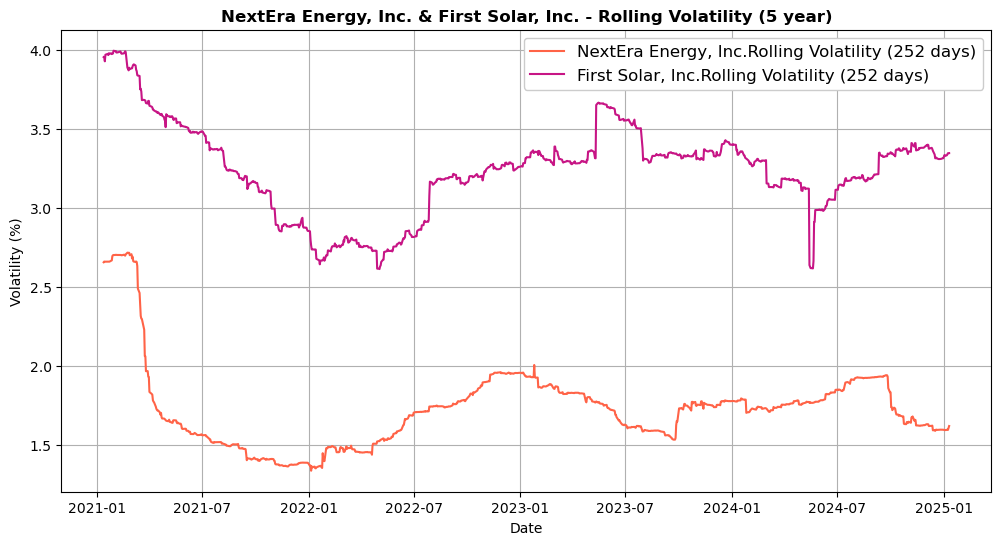

In [231]:
renew_energy_mid_term_volatility= company_volatility_plots(selected_companies=['NEE','FSLR'], timeframe='5y',fullnames=company_ticker_to_fullname, data=industry_dataframes, colours=colours_comp, rolling_window=252)

**Rolling Volatility** 

Starting with NextEra, from the plot it is clear to see that the company experienced a lower and more stable level of volatility throughout the 5 years. Even with minor fluctuations over the 5 years, the line stays within the 1.5% to 2% range for the rolling volatility. 

The rolling volatility for First Solar on the other hand remains higher, with more erratic peaks and dips throughout the 5 years. It is worth noting that at its lowest, the rolling volatility for First Solar just reaches the maximum value experienced by NextEra.

With this, investors looking for a more consistent and safer investment portfolio would likely be drawn to the NextEra. For investors less concerned with risk and seeking high rewards First Solar a better suited option.

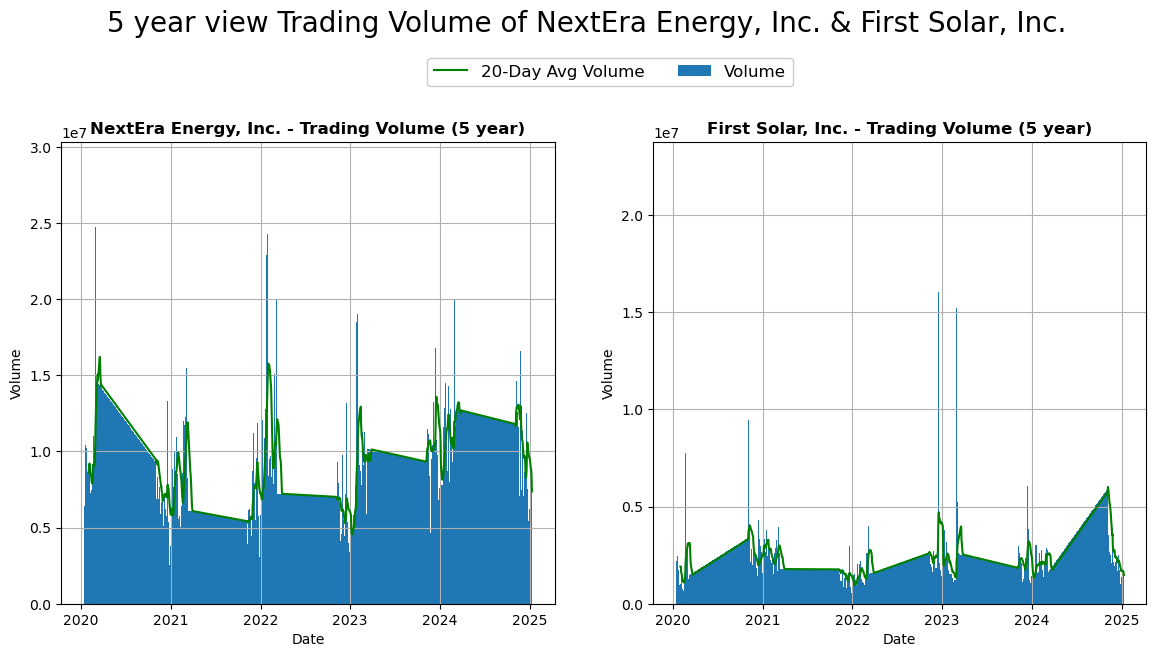

In [232]:
renew_energy_mid_term_trading_volume = company_trading_volume_plots(selected_companies=['NEE','FSLR'], timeframe='5y', fullnames=company_ticker_to_fullname, data=industry_dataframes)

**Trading Volume** 

Starting with the left plot showing the NextEra Energy trading volume trends, noticeable peaks can be seen in the volume occurring annually. This may be tied to earning reports or company announcements shared. Apart from the peaks seen annually the trading volume appears relatively stable, staying for the most part between 5 million and 15 million shares. 

First Solar in comparison has a much lower overall trading volume, only briefly breaking the 5 million shares threshold. The 20-Day average volume remained flat for the most part with slight increases. This flat and low average would typically reflect low and stable trading interest.  

From this, it can be seen that NextEra is more actively traded with steady volume patterns. Due to this, it could be said that NextEra is better for investors looking to avoid drastic risk and looking for consistent, long-term growth with lower volatility and potentially steady dividends. 

In contrast to this, investor more comfortable with risk and looking for high growth opportunities who do not higher volatile stocks may find First Solar a better fit. 

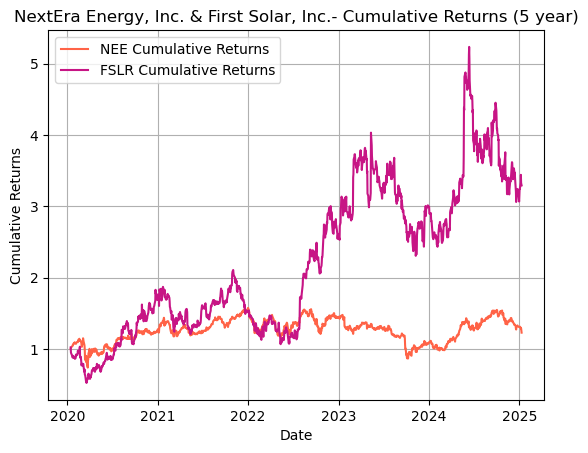

In [233]:
renew_energy_mid_term_cumulative_returns = company_cumulative_returns(selected_companies=['NEE', 'FSLR'], timeframe='5y', data=industry_dataframes, fullnames=company_ticker_to_fullname, colours=colours_comp)

**Cumulative Returns**   

Looking at the cumulative returns for NextEra, a slow gradual upward trend can be seen over the 5-year period. This slow but consistent growth for the returns suggests lower volatility for the NextEra stock. There are a number of mild dips in returns throughout the year, but these are followed by recoveries, with an overall 50% total return. 

The First Solar line plot shows significant growth for the cumulative returns, starting at 1 and reaching over 5, meaning that there was a more the 400% in returns over the 5 year timeframe.
While First Solar experienced huge growth it appears that the growth period was quite volatile by the fluctuating peaks and dips, this fluctuation is most easily seen between 2023 and mid-2024. This explosive growth, with more drastic dips in returns indicates that there is a higher risk with the First Solar stock as this may suggest the stock is more reactive and sensitive to company-specific new or industry shifts. 

Long-term investors who are looking for steady returns and predictable growth may be more likely to invests NextEra Energy stock. 
While investors looking for higher returns willing to accept the higher volatility and risk associated may be more attracted to the First Solar stock.

### Long-term analysis (10-year)

#### Apple, Inc. & Microsoft

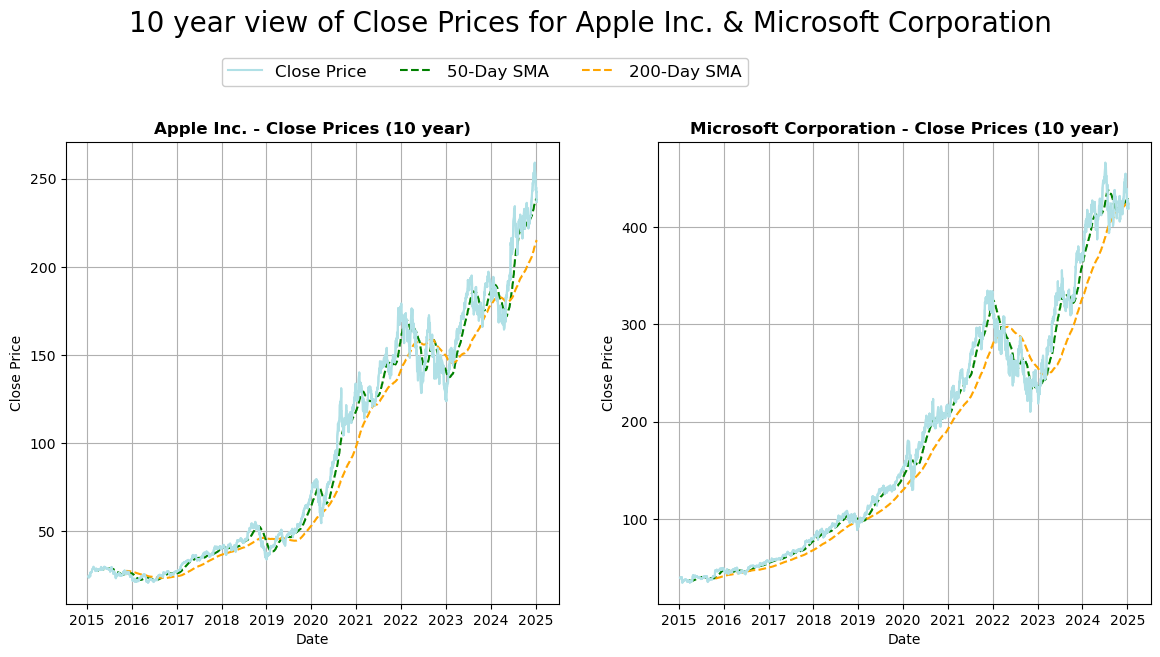

In [234]:
tech_long_term_close_plot = company_close_plots(selected_companies=['AAPL','MSFT'], timeframe='10y', data=industry_dataframes, fullnames=company_ticker_to_fullname)

**Close Price Trends**   

10 years line plot for Apple starts with a close price of near \$25 in 2015, steadily increasing in an upward trend with the close price reaching over \$250 in 2025. Brief dips in plot can be seen along the way but a strong recovery can be seen following the dips. An example is the dip seen early 2023 which is quickly followed by a steep upward trend with the close price recovered to its pre-dip value by mid-2023. 
The Microsoft plot displays a more aggressive upwards trend, with the stock start near the \$50 mark in 2015, gradually climbing in price until late 2018. There is a brief flattening in price towards the end of 2018 is following by a steep upwards growth with the close price going from \$100 in 2019 to over \$300 by end of 2022. This period of aggressive growth is then followed by an abrupt dip in price from 2022 to 2023. The close price manages a quick recovery though, with the stock returning to its pre-dip price by mid-2023, with the stock continuing to reach over \$450 by mid-2024. 
 While there are differences, largely in terms of maximum growth over the 10 year period, there are similarities between the two plots with both companies stock prices starting a downward trend in 2022 followed by a quick recovery. This may indicate an event or industry-wide factors which impacted both companies’ growth during that timeframe.

**50-Day Simple Moving Average (SMA):**  

The 50-Day SMA for both Apple and Microsoft appear closely aligned with what is seen in their stock price trends throughout the 10 years, with a strong and consistent growth trend apparent throughout both companies with occasional dips and the 50-Day SMA showing a speedy recovery. 

**200-Day Simple Moving Average (SMA):**  

The 200-Day SMAs for both companies also appear to have a very similar upward trend. The most notable difference between the two being that for Apple the upward trend is more consistent. With a smaller dip occurring in 2022 compared to the dip in Microsoft’s 200-Day SMA pattern.

**Overall**  

Apple’s stock shows a steady growth pattern with less drastic fluctuation throughout the 10 years. Microsoft also shows a somewhat comparable growth pattern, however, there is higher growth seen by Microsoft with a steeper upward trend. The downward trends for Microsoft typically have a greater loss associated.

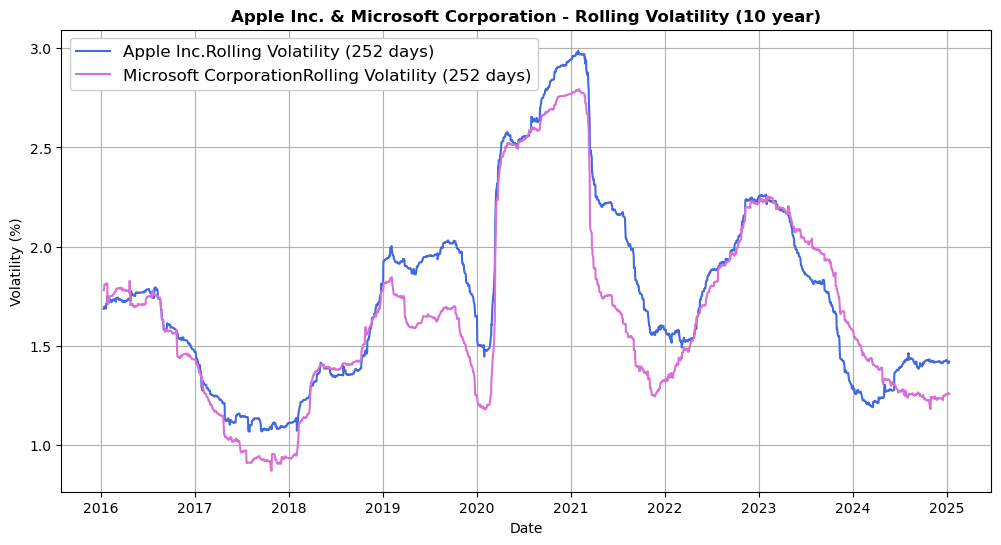

In [235]:
tech_long_term_volatility_plot = company_volatility_plots(selected_companies=['AAPL','MSFT'], timeframe='10y', data=industry_dataframes, fullnames=company_ticker_to_fullname, colours=colours_comp, rolling_window=252)

**Rolling Volatility**   

Looking at the plot above both companies again follow a very similar trend, starting off in 2016 with volatility show between the 1.5% and 2% mark. 

A downwards trend in the volatility can be seen, continuing to a low mid-2017 to the start of 2018. With both companies following a similar pattern it may suggest that there was broader industry-wide volatility in the market.  

The low volatility steadily increases for both companies throughout 2018. In 2019 the volatility trend starts to flatten before a quick dip and then a drastic incline in rolling volatility in 2020 potentially linked to the effects on the wider market post-pandemic. From 2021 to 2025 there appears to be a gradual decrease with both companies returning near their volatility level pre-pandemic.

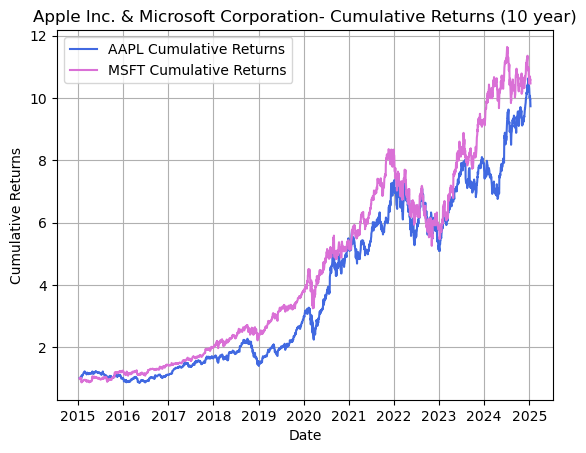

In [236]:
tech_long_term_cumulative_returns = company_cumulative_returns(selected_companies=['AAPL','MSFT'], timeframe='10y', data=industry_dataframes, fullnames=company_ticker_to_fullname, colours=colours_comp)

**Cumulative Returns**   

The cumulative returns for both Apple and Microsoft appear closely aligned from 2015 to mid-2018, indicating close levels of performance for both companies. At this point the trends begin to diverge more with Microsoft experiencing higher growth rate than Apple during 2020 to 2022. 

A downward trend can be seen in both companies from 2022 to 2023 before a speedy recovery by both companies.

Both companies display strong growth and long-term performance throughout the 10-year span for the cumulative returns. 

#### NextEra Energy, Inc. & First Solar, Inc.

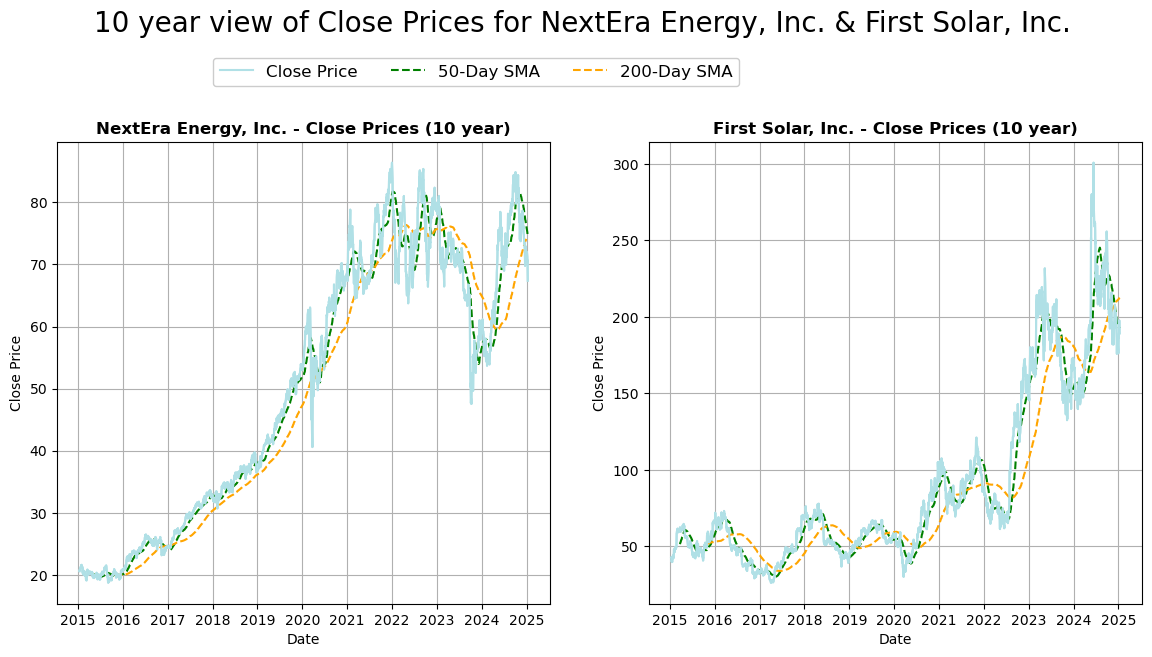

In [237]:
renew_long_term_close_plot = company_close_plots(selected_companies=['NEE','FSLR'], timeframe='10y', data=industry_dataframes, fullnames=company_ticker_to_fullname)

**Close Price Trends**:   

The 10-year plot for NextEra Energy shows a consistent upward trend starting around the \$20 mark in 2015 and steadily growing reaching a max over \$85 in 2022. While there are a number of minor dips during the period of growth, the most notable downward trend occurred in 2023. With the close price hovering around the \$80 mark beginning of 2023 there is a drastic downward trend seen from beginning 2023, coming to an end before 2023 is finished. A partial recovery is then seen throughout 2024 with the shares reaching near \$85 mark again before a slight dip seen before entering 2025. 

The 10-year pattern for First Solar shows a more volatile growth trend compared to NextEra. Throughout the 10-year period a series of fluctuations in share price can be seen with the large surge between mid-2020 and mid-2023, starting with a close price of approximately \$75 and rising continuously to over \$225 per share mid-2023 before a dip. The next large surge can be seen in the beginning of 2024, with the close price doubling during the first half of the year. This is followed by another downward trend for the second half of 2024 leading into 2025. 

**50-Day Simple Moving Average (SMA):**  

For NextEra Energy the 50-Day SMA hugs the close price line tightly. In comparison the First Solar plot shows more drastic and reoccurring crossover between the 50-Day SMA and the 200-Day SMA due to the more volatile nature of the First Solar plot with dramatic price fluctuation.  

**200-Day Simple Moving Average (SMA):**  

A clear upward trend can be seen for the 200-Day SMA of the NextEra Energy stock, matching the close price trends closely. The 200-Day SMA can be seen to dip in 2023, again aligning with the close price downward trend seen during that time. At the beginning of 2024 the Next Era Energy stock begins to recovery and with this the 200-Day SMA begins to trend upwards in the before mid-2024, appearing to almost make a full recovery before 2025. 

The 200-Day SMA for First Solar is more volatile mirroring the close price pattern, when the close price drastically increases the 200-Day SMA also follows. Due to the volatility of the stocks and dramatic changes in close prices in the 10-year span, more frequent crossover of the 50-Day SMA and 200-Day SMA trends can be seen. 

**Overall**  

Those looking to invest in a renewable energy company may be more attracted to the NextEra Energy stock due to its steady growth other the 10-year period if they are looking for lower risk options. In contrast, the higher growth displayed in the 10 years for First Solar may appeal to those who are more risk-tolerant and looking for larger gains.

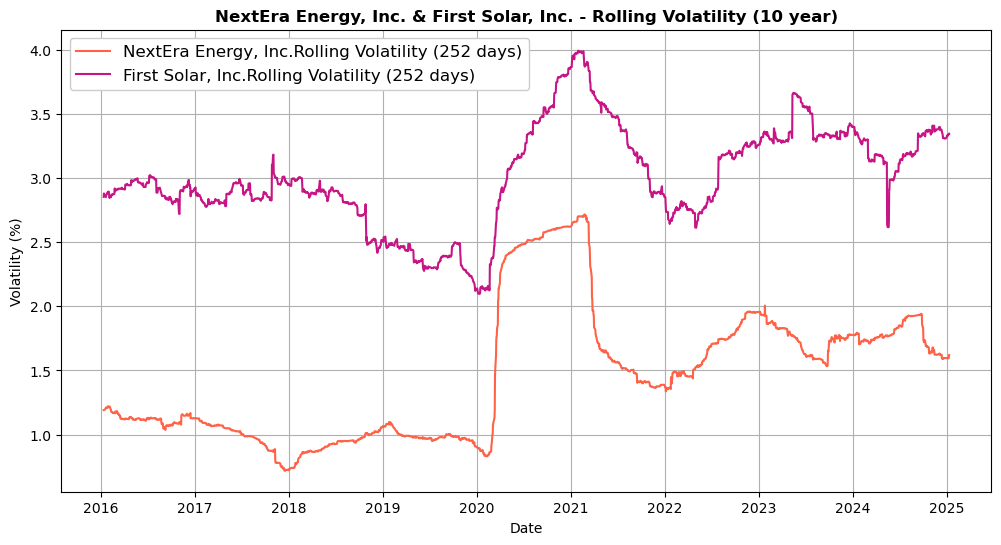

In [238]:
renew_long_term_volatility_plot = company_volatility_plots(selected_companies=['NEE','FSLR'], timeframe='10y', data=industry_dataframes, fullnames=company_ticker_to_fullname, colours=colours_comp, rolling_window=252)

**Rolling Volatility:**

The 10-year rolling volatility plot for NextEra Energy and First Solar shows that both companies follow similar patterns and periods of incline and dips in the trend. However, the ranges of volatility between the two are very different between the two. 

First Solar has consistently higher levels of volatility ranging between 2% and 3.5% volatility throughout the 10 years excluding a period of heightened volatility for NextEra Energy between 2020 to 2021. 

NextEra Energy in contrast maintained lower volatility throughout the 10-year period, staying primarily between 1% and 2% for most of the time. Like First Solar, 2020 to 2021 brought a spike in volatility indicating industry or market wide volatility, likely in line with the post-pandemic effects on the wider market. 

The lower volatility of NextEra Energy’s stock indicates a stable growth pattern for the stock making it more attractive for investors looking to avoid higher risk levels and wanting steady returns. With First Solar the opposite is true, the higher volatility shown over the 10-year period likely attracting investors wanting higher rewards and less wary of risk.

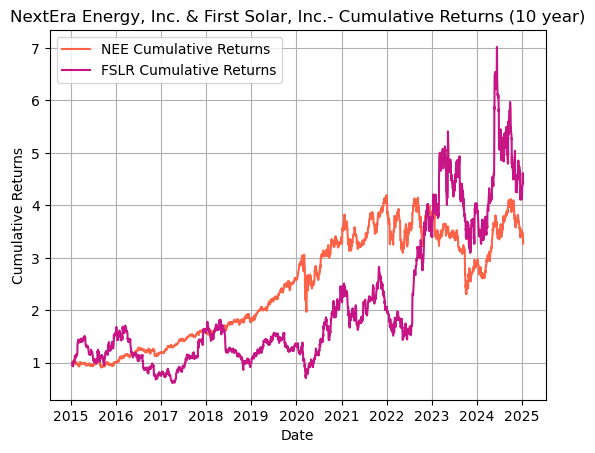

In [239]:
renew_energy_long_term_cumulative_returns = company_cumulative_returns(selected_companies=['NEE','FSLR'], timeframe='10y', data=industry_dataframes, fullnames=company_ticker_to_fullname, colours=colours_comp)

**Cumulative Returns**:   

From NextEra Energy a steadier increase in the cumulative returns can be seen gradually throughout the 10 years. In 2022, 4 times the initial value recorded in 2015 was reached. First Solar on the other hand shows a more volatile and drastic growth pattern, reaching its peak in 2024, with 7 times the initial value from 2015 recorded. 

While First Solar surpassed NextEra Energy in performance at points in the 10-year period, NextEra Energy shows a consistent low-risk long term investment better suited for investors seeking stable long-term growth. The differences shown in the plot highlights the versatility of stability and high-risk high-reward stocks in the renewable energy industry.

## Industry-Wide performance

### All industries over past 1 year

As a first step in looking at the performance of the industries the data will be resampled.  
For each industry the data is resampled to show the mean amount of the close prices for the companies in that industry at a 1 day interval.   

In [240]:
# creating an empty DataFrame to store the combined data for the mean close prices for all timeframes
industry_mean_close_combined = pd.DataFrame()

# iterating through time periods and industries to calculate mean Close prices
for time_period in ['1y', '5y', '10y']:
    for industry in industries.keys():
        # skipping 5y and 10y for industries without enough data (Quatum computing and Electronic Vehicles)
        if time_period in ['5y', '10y'] and industry not in ['Renewable Energy', 'Technology']:
            continue 

        # filtering the dataframe for the specific industry and time period
        industry_df = industry_dataframes[time_period][industry_dataframes[time_period]['Industry'] == industry]

        # resampling the data by day and calculatinig the mean close price
        daily_mean = industry_df['Close'].resample('D').mean()

        temp_df = pd.DataFrame(daily_mean)  # converting the data to a dataframe
        # assigning the values for the industry and timeframe column
        # these columns will be important for enabling the data in the dataframe to be selected for a specific time period or industry
        temp_df['Industry'] = industry
        temp_df['Timeframe'] = time_period

        # appending the data to the combined dataframe
        industry_mean_close_combined = pd.concat([industry_mean_close_combined, temp_df])

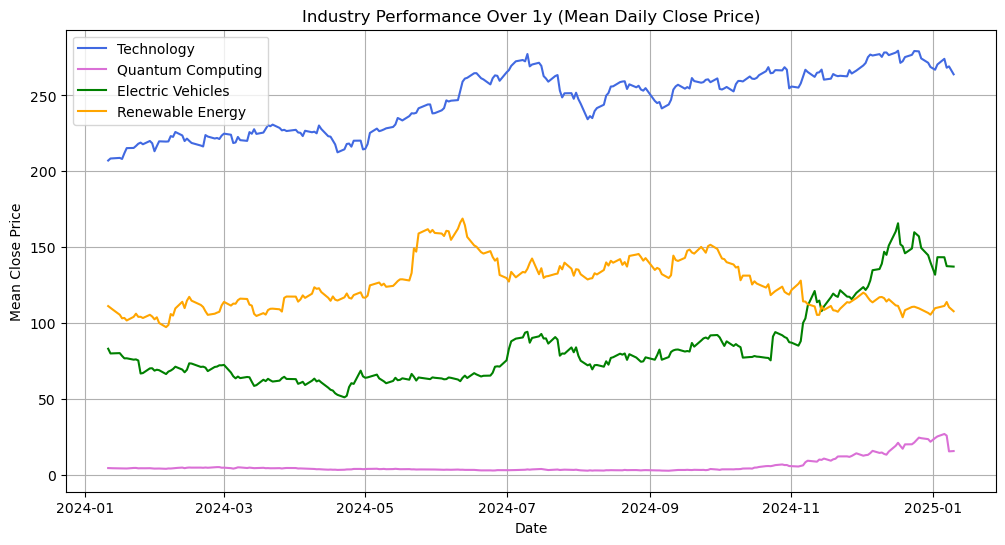

In [241]:
industry_close_prices = industry_close_prices_plot(data=industry_mean_close_combined, time='1y', colours=colours)

**Industry Performance Over 1-year:**

Starting from top to bottom, the Technology industry had the highest mean close prices consistently throughout the year starting above \$200 and finishing the year at over \$250. The steepest growth period can be seen from May to July which may be impacted by the growth in AI experienced throughout 2024. With it reported that the market for AI “grew beyond 184 billion U.S. dollars in 2024” .[^4]  

Minor pullbacks can be seen throughout the year, visualised by little dips in the plot, the most noteworthy occurring in August. However, this downward trend seen in August appears to have stabilized by the end of the year and the close price is back to its pre-dip value. 

Moving down next to Renewable Energy, a gradual upward trend can be seen for the first half of the year indicating moderate growth in the sector. This peaks mid-year before beginning a steady decline throughout the year. While there appears to be a slight recovery seen from July to October, the decline continues consistently from October onwards. 

As the renewable energy industry is highly affected by external factors like policy changes this decline may be linked to the US election with President Donald Trump making multiple announcements in the run up to the election. One example is an article from The Guardian which details President Trump’s “promise to repeal major climate policies passed during Joe Biden’s presidency” and the potential effect this would have on investment in the renewable energy sector. [^5]

Switching to the Electric Vehicles sector, 2024 appears to have started off on a slight decline until end of April, gradually gaining momentum until July before flattening until end of October. From this point on the Electric Vehicles sector begins to show sharp growth from November onwards. 

This could also be in part a result of the build up to the US election, Elon Musk (founder and CEO of Tesla) gathering heightened media attention from November due to his seemingly growing relationship and support of Trump. First appearing with Trump in October 2024 [^6] and continuing to support and make appearances alongside Trump throughout the end of 2024 donning the nickname “First Buddy” with numerous media outlets reporting on the duo their relationship and its potential positive impact Trump’s anti-EV policy could have for a titan of the EV sector like Tesla. [^7]

The Quantum Computing industry has the flattest mean close price over the year before gradually rising towards end of 2024. This industry is still in the very early stages of development, with early milestones being announced throughout the year by large companies. 

One example is IBM launch of “it’s most advanced quantum computer yet” [^8], another is D-Wave’s press release that record performance breakthroughs were recorded for their Advantage2 processor solving a range of problems 25,000 times faster. [^9]  

As the Quantum Computing industry is in such early stages it is more likely to be influenced by speculation and industry news. This sentiment could also be furthered by the dip in early 2025 after Nvidia CEO shared his belief that “practical uses for quantum computing were more than a decade away.” [^10]

In [242]:
# calculating the volatility and storing in the dataframes for the different time periods
for time_period in ['5y', '1y', '10y']: 

    industry_dataframes[time_period]['Volatility'] = (
        (industry_dataframes[time_period]['High'] - industry_dataframes[time_period]['Low']) / 
        industry_dataframes[time_period]['Low']
) * 100
    
# print(industry_dataframes['10y']) for testing to see if volatility is added

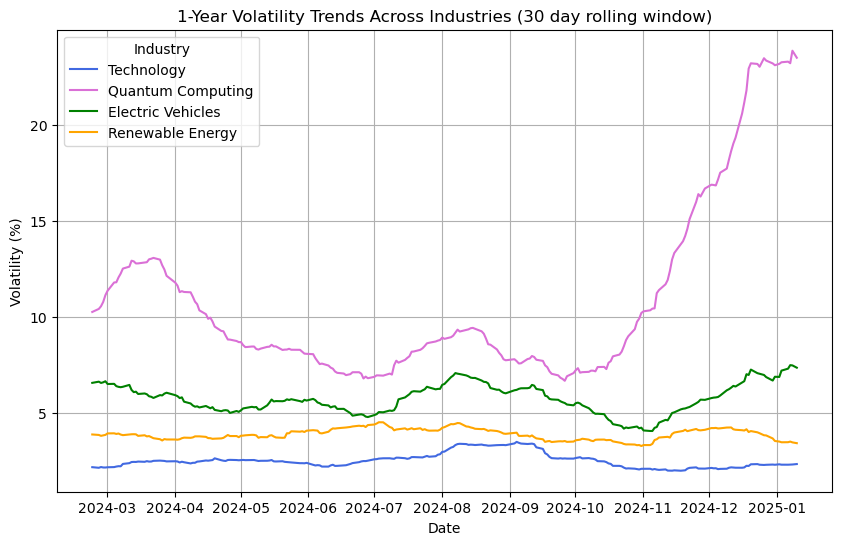

In [243]:
plt.figure(figsize=(10, 6))

# looping through the 1y dataset looking for unique values in industries
for industry in industry_dataframes['1y']['Industry'].unique():
    # filtering the data for the current industry
    industry_data = industry_dataframes['1y'][industry_dataframes['1y']['Industry'] == industry]

    # grouping the data by date and calculating the mean volatility using the agg function
    grouped_data = industry_data.groupby(industry_data.index).agg({
        'Volatility': 'mean'  # Aggregate volatility
    })

    # applying a 3-day rolling average to smooth the volatility
    grouped_data['Volatility'] = grouped_data['Volatility'].rolling(window=30).mean()


    # getting the colour from the colours dictionary specified for that industry
    color = colours.get(industry)

    # plotting the aggregated volatility for the industry
    plt.plot(grouped_data.index, grouped_data['Volatility'], label=industry, color=color)

# adding labels and title
plt.title('1-Year Volatility Trends Across Industries (30 day rolling window)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend(title='Industry')
plt.grid(True)

plt.show()


**Industry Volatility Over 1-year:**   

Working from least to most volatile industry, the Technology industry is consistently below the other industries throughout the duration of the year. This could be in part due to the maturity of the industry with the companies within (Apple, Microsoft and Nvidia) all being well established companies in their own accord. This overall view of the rolling volatility for the year shows the volatility staying around the 2-3% range for most of the year indicating the Technology industry is a stead and lower risk sector for investment. 

Second lowest for volatility for the year is the Renewable Energy industry, which appears to have the flattest line for volatility throughout the year. When looking at the rolling volatility for the industry, the mid and end year fluctuations observed when looking at the Renewable Energy companies separately are barely noticeable when compared to the upward and downward trends of the remaining industries, showing its long-term stability.

Moving up to our second highest industry for volatility Electric Vehicles, even with the 30-day rolling window smoothing out the short-term spikes in volatility, gradual increases in market risk at different stages of the year are visible. Moderate volatility can be seen throughout the year with the second half of the year showing a gradual risk in the volatility pattern. 

Quantum Computing appears as the leading industry in terms of volatility for 2024, with volatility increasing to over double the amount at the beginning of 2024 (from 10% to over 25%). The most notable observation being the steep and steady upwards turn in volatility from mid-October to end of 2024, aligning with growing intertest in and industrial developments in Quantum Computing throughout 2024. 


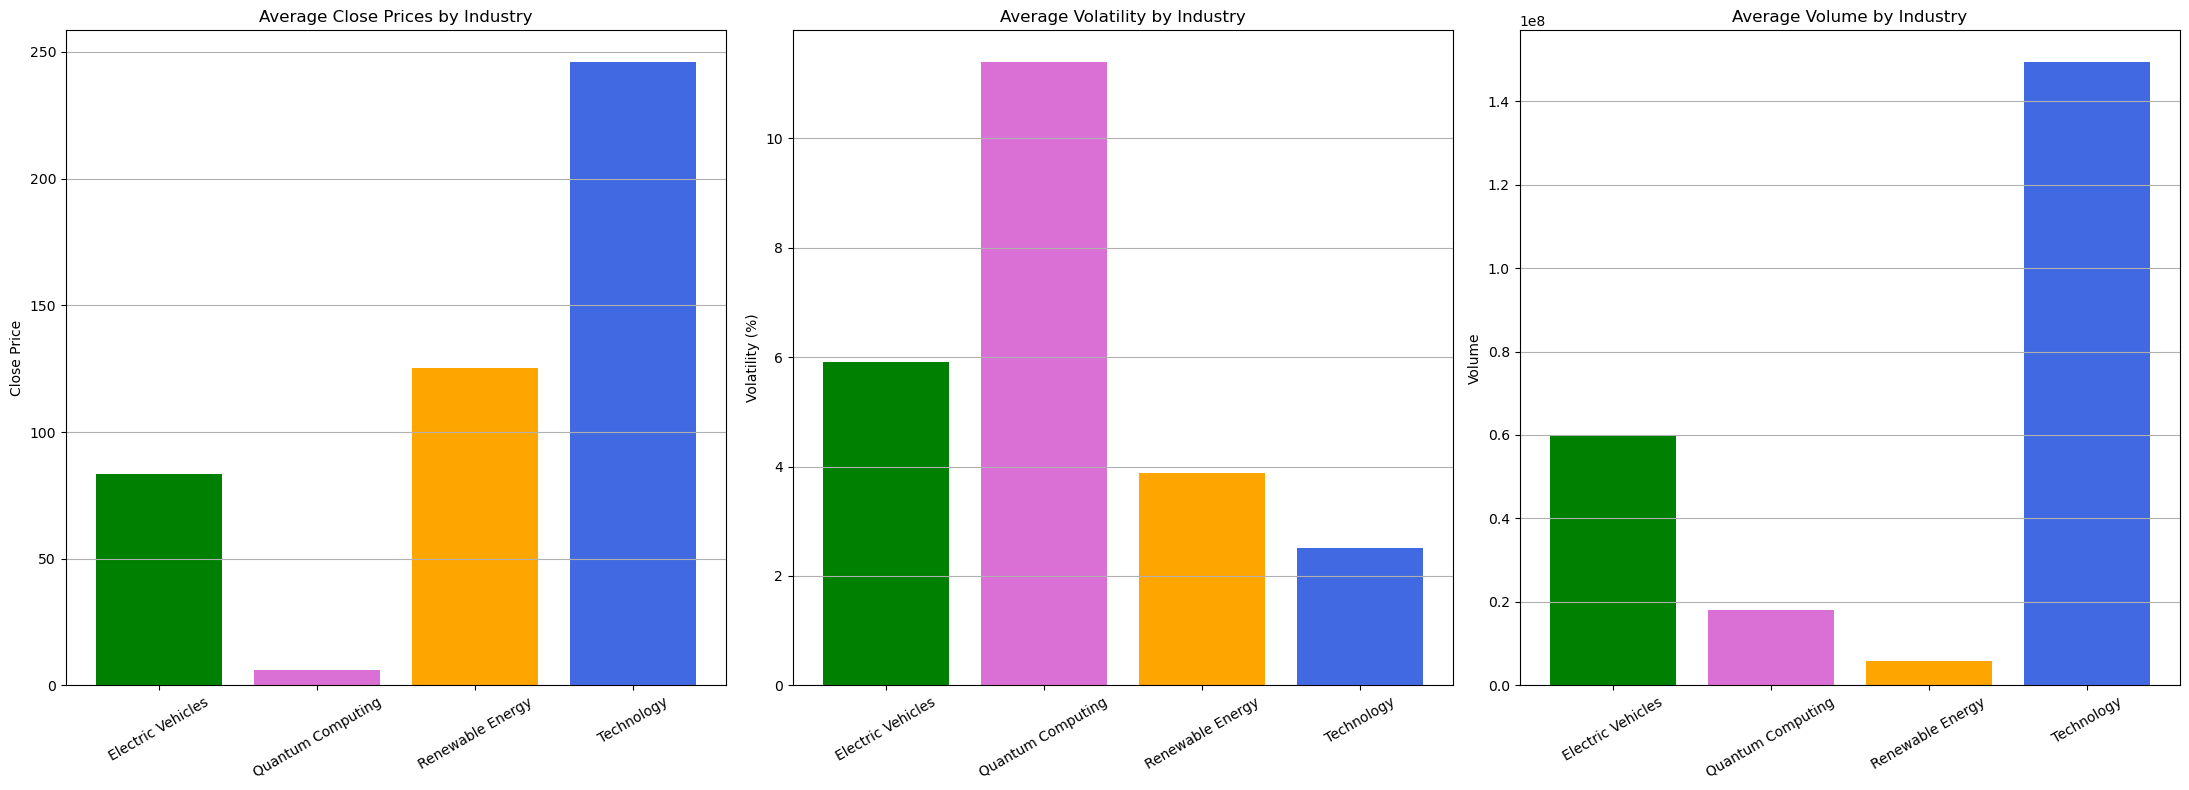

In [244]:

# getting the average per industry for the close, volatility and volume data for the 1y df
industry_avg = industry_dataframes['1y'].groupby('Industry')[['Close', 'Volatility', 'Volume']].mean()

# creating a suplot to show the values per industry
plt.figure(figsize=(22,8)) # setting the size of the overall image to increase readability

plt.subplot(1, 3, 1) # first looking at the close values across the industries 
plt.bar(industry_avg.index, industry_avg['Close'], # using the index for industry_avg as the bases for the x axis and the labels
        color=[colours.get(ind) for ind in industry_avg.index] ) # using the industry names in the index for the grouped values to find the correct colour and assign it 
plt.title('Average Close Prices by Industry')
plt.xticks(rotation=30) # rotating the x labels so they are not overlapping
plt.ylabel('Close Price')
plt.grid(visible=True, which='major', axis='y') # adding lines on the y axis to help readability

# next the process is repeated for the volatility and volume data per indusrty and plotted

plt.subplot(1, 3, 2)
plt.bar(industry_avg.index, industry_avg['Volatility'], 
        color=[colours.get(ind) for ind in industry_avg.index])
plt.title('Average Volatility by Industry')
plt.xticks(rotation=30)
plt.ylabel('Volatility (%)')
plt.grid(visible=True, which='major', axis='y')

plt.subplot(1, 3, 3)
plt.bar(industry_avg.index, industry_avg['Volume'], 
        color=[colours.get(ind) for ind in industry_avg.index])
plt.title('Average Volume by Industry')
plt.xticks(rotation=30)
plt.ylabel('Volume')
plt.grid(visible=True, which='major', axis='y')

plt.tight_layout()
plt.show()


**Average Close Prices, Volatility and Volume Per Industry:**  

When assessing the industries together on their overall performance in terms of Close Price, Volatility and Volume the Technology industry appears to lead the pack with less volatility, higher trading volumes and the higher Close Prices recorded. 

Renewable Energy is the next in line when looking at performance in terms of Close Prices and Volatility. However, there appears to be slower activity within the Renewable Energy shares as it ranked in the lowest trading volume of the industries. 

Electric Vehicles show a more moderate risk looking at the volatility and strong investor interest, ranking the second largest levels for volatility and the trading volumes recorded. The mean Close Price also shows a strong market value of around \$85 indicated by the chart.

Quantum Computing’s results appear to match that of a more speculative market with the highest volatility recorded and the lowest mean Close Price with quite a gap between the it and the next lowest stock valued stock. 


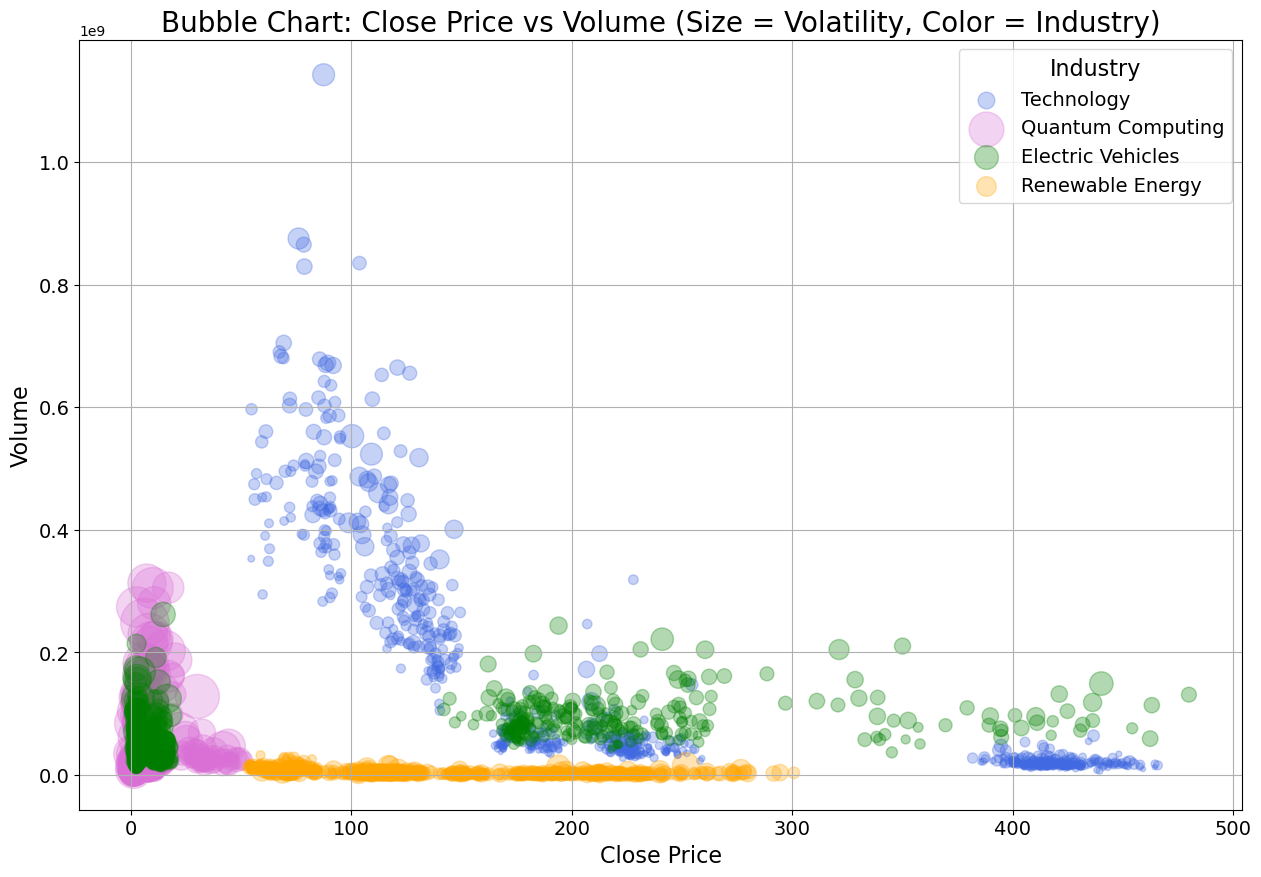

In [245]:
# creating a scatter chart with a 3rd dimension of increasing the size of the marker depending on the volatility of the stock, colored by industry

plt.figure(figsize=(15, 10))

# looping through each industry to plot them with different colors
for industry in industry_dataframes['1y']['Industry'].unique():
    # filtering data for the current industry
    industry_data = industry_dataframes['1y'][industry_dataframes['1y']['Industry'] == industry]
        # getting the colour from the colours dictionary specified for that industry
    color = colours.get(industry)
    # plotting the scatter plot for the current industry
    plt.scatter(industry_data['Close'],  # setting the x-axis
                industry_data['Volume'],  # setting the y-axis
                s=industry_data['Volatility'] * 20,  # setting the size of the markers
                alpha=0.3,  # setting the transparency
                label=industry, color=color)  # labeling by industry

# customising the plot
plt.title('Bubble Chart: Close Price vs Volume (Size = Volatility, Color = Industry)', fontsize =20)
plt.xlabel('Close Price', fontsize=16)
plt.ylabel('Volume', fontsize=16)
plt.legend(fontsize=14, title='Industry', title_fontsize=16)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


**Close Prices vs. Volume (considering Volatility ):** 

Using a bubble chart, the same 3 factors can be visualised looking at the Close Price vs the Trading Volume in the form of a scatter plot and including the Volatility represented by the size of each marker, the larger the marker the higher volatility. 

The Quantum Computing industry is stand out in terms of volatility it the largest markers on the plot being seen for Quantum Computing, clustering together at the lower right of the plot indicating lower close prices and trading volume numbers. 

A number of markers for the Electric Vehicles can also be seen clustered together in the lower right of the plot. However, there is a wider spread of the EV markers over all with a moderate balance seen between the price, volume and volatility. 

The markers for Renewable Energy reflect the stable low volatility seen reflected in the previous plots for volatility. The lower trading volumes can also be seen in the plot with the markers hovering consistently along the bottom of the plot in a stable line. 

The Technology industry is the clear outlier in terms of trading volume while also demonstrating lower volatility compared to Quantum Computing and Electric Vehicles. A cluster of markers can also be seen at the higher end of the Close Prices, with these entries remaining low in volatility as seen by the small marker size. 

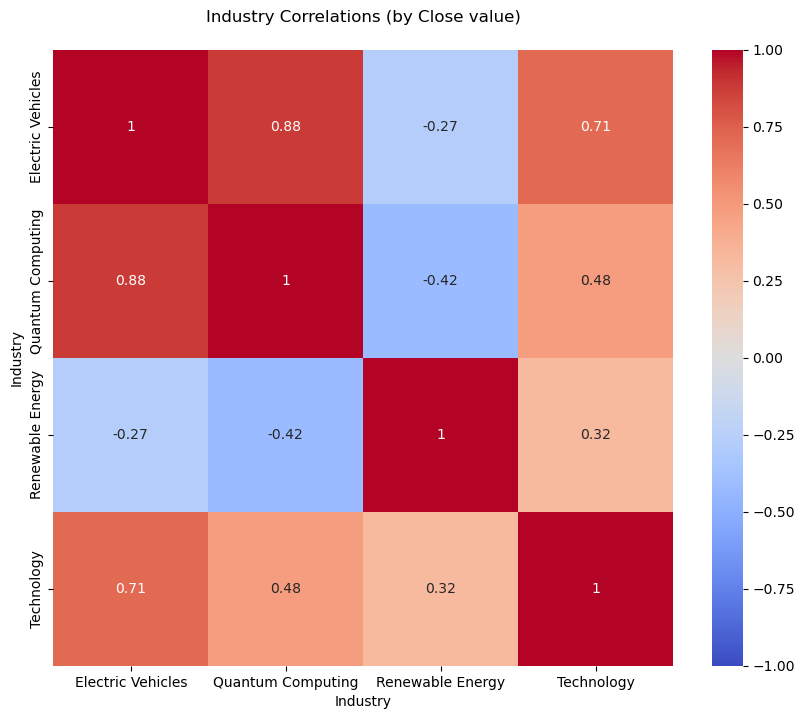

In [246]:
# restructuring the data to get the close prices based on the 'Close' prices for the industries
industry_corr = industry_dataframes['1y'].pivot_table(index=industry_dataframes['1y'].index, columns='Industry', values='Close')
#print(industry_corr) for testing results for .pivot_table

# calculating the correlation between industries
industry_corr = industry_corr.corr()

# plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(industry_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Industry Correlations (by Close value)', pad=20)
plt.grid(False)
plt.show()


**Industry Correlations (using Close Price):** 

When comparing the industries using the heatmap above there are a few interesting observations. 
Electric Vehicles and Quantum Computing show a strong positive correlation with a coefficient of 0.88. This indicates that these industries often move in the same direction. This could potentially reflect that both have a shared level of impact from market speculation or that there is strong interest from investors for innovation-driven industries such as Electric Vehicles and Quantum Computing.

Electric Vehicles and Technology have the next highest correlation coefficient of 0.71, this indicates a strong relationship between the two industries. For the most part the shares are typically moving in a similar direction while not being as closely aligned as that between Electric Vehicles and Quantum Computing. 

A negative relationship can be seen between Renewable Energy and Quantum Computing and Electric Vehicles. This indicating that as Renewable Energy close prices decline the Quantum Computing and Electric Vehicles stocks are likely to increase in price.

Compared to the strong correlation between the Technology industry and Electric Vehicles, a much weaker correlation can be seen between Technology and Renewable Energy. With a correlation coefficient of 0.32, indicating a limited positive connection between the two industries. 

A general best practise for investing is for an investor to ensure their portfolio is diverse, as industries or shares which are closely linked may pose a greater risk of loss if there is a downward trend. For investors looking to diversify their portfolio and avoid investing in, industries with a moderate to weak connection may provide a safer option to expand a portfolio while avoiding investing too much in industries following similar trends.

In [247]:
industry_returns = create_industry_returns_df(industries, industry_dataframes) # calling a function which creates a table showing the industry return per industry

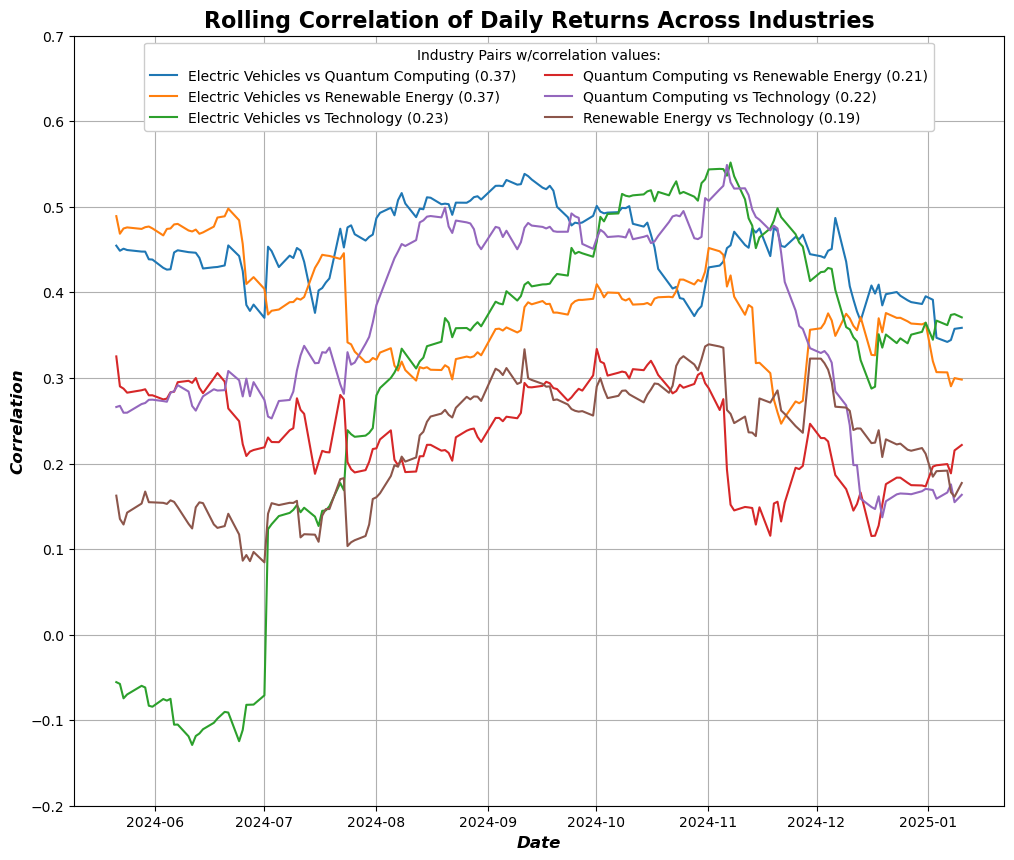

In [248]:
# rolling Correlation Analysis for all industry pairs
plt.figure(figsize=(12, 10))
for i, industry1 in enumerate(industry_returns.columns): # parent loop cycling through the column names for industry_returns to use as the first value for the correlation
    for j, industry2 in enumerate(industry_returns.columns): # nested loop cycling through the column names for industry_returns to use as the second value for the correlation
        if i < j:  # if statement to avoid duplicate pairs and self-pairs based comparison of the values of the i and j counters 
            rolling_corr = industry_returns[industry1].rolling(window=90).corr( # checking the correlation per industry pair with  90 day rolling window
                industry_returns[industry2])
            plt.plot(rolling_corr, label=f'{industry1} vs {industry2} ({industry_returns[industry1].corr(industry_returns[industry2]):.2f})') # plotting the results and showing the correlation coefficient value in the legend

# customizing the visuals of the plot
plt.title('Rolling Correlation of Daily Returns Across Industries', fontweight='bold', fontsize=16)
plt.xlabel('Date', fontsize=12, fontweight='bold', fontstyle='italic')
plt.ylabel('Correlation', fontsize=12, fontweight='bold', fontstyle='italic')
plt.ylim(-0.2, 0.7) # setting y min and max values to match the range of the possible answers for the correlation coefficient
plt.grid(True)
plt.legend(loc='upper center', ncols = 2, fontsize=10, framealpha=1.0, title='Industry Pairs w/correlation values:') # customising the legend to make it more readible
plt.show()

**Rolling Industry Correlations (using Daily Returns):** 

The above line plot shows how the relationship between the industries varies throughout the year when focusing on the daily return trends for the industries, capturing short-term shifts in the market. 

It can be seen from the plot that both Electric Vehicles and Quantum Computing and Electric Vehicles and Renewable Energy have a correlation of 0.37. Both pairings start the year with a higher correlation between their daily returns with this fluctuating as the year goes, as 2024 ends the relationship between both pairings appear to have softened.  

Electric Vehicles and Technology appear to have the biggest change in their correlation throughout the course of the year. Starting off with a negative correlation, a steep upward trend is seen reaching a positive correlation in November near 0.5, indicating that the relationship between the industries is becoming more closely linked.

Throughout the year correlation for Quantum Computing and Technology is in an upward trend, steeply rising in correlation mid-August along.  Later in the year a drastic drop in correlation can be seen, this divergence in the two industry stocks may be due to press coverage indicating that quantum technology is still in very early stages and has a long way to go compared to the more traditional and established companies within the Technology Industry. 

Quantum Computing and Renewable Energy, follow a similar trend to the pairing for Electic Vehicles and Renewable Energy, both starting the year with a stronger correlation than seen at the end of the year. Interestingly both appear to dip at the same time in November. This slight divergence in the relationship between the pairs may be influenced by the wider disruption to the Renewable Energy industry due to the policy changes promised by Trump during the US election. 

The relationship between Renewable Energy and Technology maintains a weak positive correlation throughout the year. While there is fluctuation the year progresses, the correlation is seen to return almost too it’s starting point by end of year. 

Overall, these shifting correlations highlight how industry relationships are influenced by external factors and are ever changing. Showing the importance of continuous monitoring for informed investment decisions


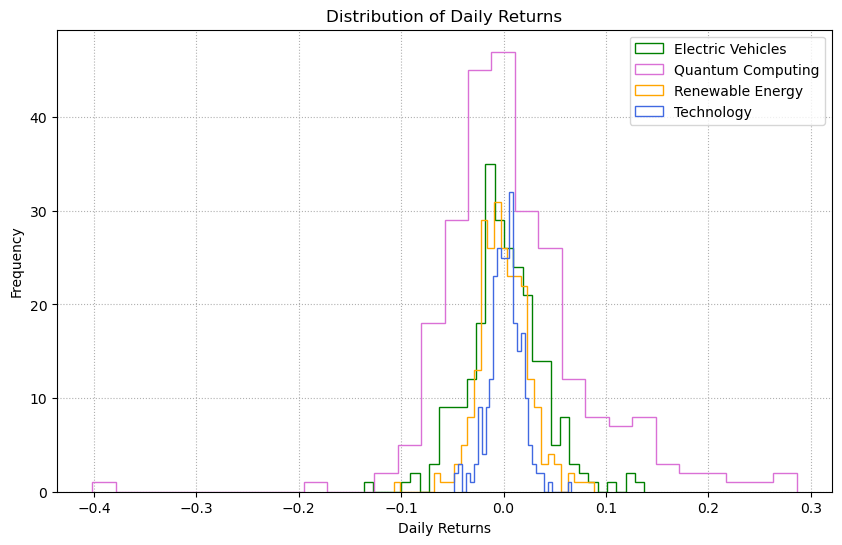

In [249]:
# plotting a histogram to show the distribution of the daily returns per industry 
# getting the colour from the colours dictionary specified for that industry
color = colours.get(industry)

# creating plot 
plt.figure(figsize=(10, 6))

# Prioritize Quantum Computing to plot first
industries_order = ['Quantum Computing'] + [industry for industry in industry_returns.columns if industry != 'Quantum Computing']

for i, industry in enumerate(industry_returns.columns): # looping through the industry_returns header names to dynamically use them as the value for the histogram
    color = colours.get(industry) # getting the specified colour for the industry from the dictionary containing the colours
    # plotting as outlined histograms to make it easier to see all industries as there is large overlap happening 
    plt.hist(industry_returns[industry], bins=30, histtype='step', linewidth=1, label=industry, color=color)


# customising the plot title and labels
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend() # adding legend
plt.grid(True, linestyle=':') # adding grid to increase readablity
plt.show()


**Distribution of Daily Returns:** 

When looking at the distribution of the Daily Returns across the industry, Quantum Computing appears to occupy most of the space on the histogram. The widespread distribution across the x-axis highlights the volatility of the stock, with extreme price swings show by the outliers on either end of the x-axis. Quantum Computing also has the tallest central peak close to the 0% Daily Returns in the histogram, showing that most days have small changes in returns however, the spread of the distribution shows that when price movements happen, they tend to be quite large. 

The Electric Vehicles industry shows the next amount of moderate volatility. While the shape for the distribution is far less spread out than the Quantum Computing Industry, it still has a wider spread than Technology and Renewable Energy indicating higher volatility than the latter. The visibility of tails left and right of the primarily unimodal shape indicate occasional larger movement in the stocks. 

Both Renewable Energy and Technology show narrow distribution with Renewable Energy having heavier tails which may indicate slightly higher volatility of the industry compared to that of the Technology industry. The narrow distribution of both industries places them at the lower end levels of volatility experienced compared to that of Quantum Computing and Electric Vehicles. 


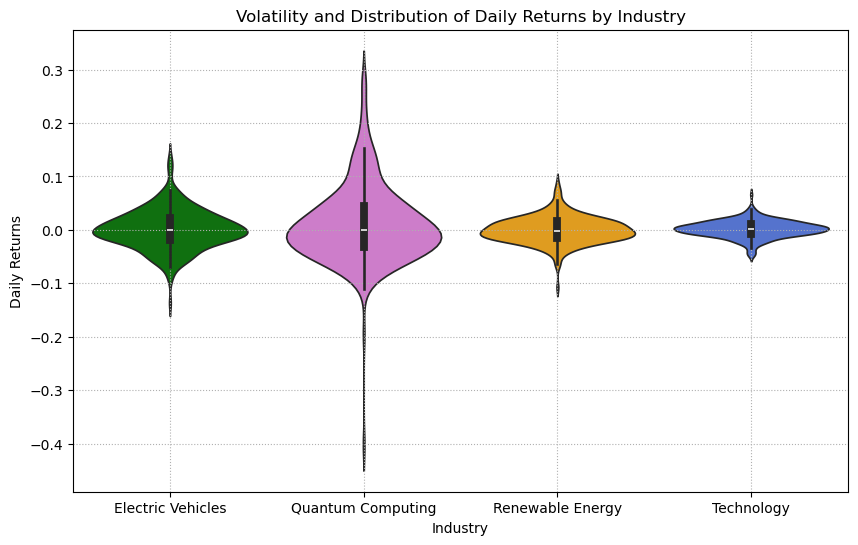

In [250]:

plt.figure(figsize=(10, 6))
sns.violinplot(data=industry_returns, palette=colours)
plt.title('Volatility and Distribution of Daily Returns by Industry')
plt.xlabel('Industry')
plt.ylabel('Daily Returns')
plt.grid(True, linestyle=':')
plt.show()


**Volatility and Distribution of Daily Returns:** 

The above violin plot gives another view on the Distribution of the Daily Returns also considering the volatility of the Daily Returns per Industry. 

The Quantum Computing violin stands out among the rest of the industries, with a vertical length of the violin showing wide spread of gains and loses indicating higher volatility of the stock. The wider midsection of the which reflects a wider range in the daily returns, the widest part of the midsection lies below the 0% daily return line suggesting that the daily returns were typically in the negative values more frequently than having positive returns. 

The violin for Electric Vehicles is next in length with a moderate spread of the daily returns, with most concentrated around the 0%. The width of the violin aligns very closely to the 0% line, with just a slight negative bias seen with the shape being slight asymmetrical with more of the width of the violin sitting under the 0% mark, indicating that while daily returns are more stable than that in Quantum Computer, there is likely still a higher frequency in negative daily returns vs positive.

Renewable Energy demonstrates a shorter length in the vertical spread of the plot indicating less volatility for the industry. It also follows the pattern seen by Quantum Computing and Electric Vehicles where the widest part of the violin lying below the 0% daily return line. 

The least vertical spread can be seen in the violin for the Technology industry, highlight the stability of the stock with consistent returns close to the 0% mark. Unlike the other industries, the widest spread of the midsection for the violin is slightly above the 0% daily returns, indicating that the sector experienced higher frequency in positive daily returns versus negative returns. The violin for the Technology sector further shows the stability in the stock with it being the shortest and most narrow seen among the industries.

## Conclusion

The analysis of the financial datasets throughout this notebook, helps provide an insight into the ever changing and complex nature of the stock market. Inspecting the performance of the different industries and companies over multiple timeframes.

From this analysis it can be seen that certain industries may appear to more conservative investors, such as the Technology industry, due to the steady growth and lower volatility shown for the sector. 

While the Renewable Energy industry showed stable long-term growth, the deeper dive into the NextEra Energy and First Solar individual performance demonstrates that while an industry may appear stable, it should not automatically be assumed that companies within that sector are experiencing the same performance across the board. Take NextEra Energy’s stable returns in comparison to First Solar’s more volatile and rapid growth as an example of this, with First Solar's more volatile performance might suit those with a higher risk appetite. 

For the more risk-tolerant investor an industry such as Quantum Computing may be more attractive due to the high volatility and the potential for high-reward associated. Electric Vehicles on the other hand so a more moderate volatility overall. With some companies such as Tesla showing explosive growth throughout 2024 and others like Rivian struggling to maintain their share price. 

Analysis of the correlation coefficient between the industries highlighted the relationships of the different pairs and how they relate to each other. Some pairings like Electric Vehicles and Quantum Computing displayed a strong connection. While Renewable Energy was seen to have a weaker correlation with the other industries, highlight its potential attraction for investors who are looking to diversify their portfolio.

This notebook has covered some crucial aspects to be considered before investing such as stock price, volatility trends and even how external factors such as political events and media coverage may influence the market. With that being said, this analysis only touches the tip of the iceberg when it comes to level depth possible when analysing the stock market. 

For the different types of investors, whether conservative and looking for steady growth or risk-tolerant hoping to find high-reward opportunity, it is important to research and understand the trends being experienced in the stock market and their potential causes when investing. While investing may be simpler than ever and possible at the click of a button, it does not make it easy. 


----
End


[^1]: https://www.wallstreetzen.com/blog/investing-quotes/?utm_source=chatgpt.com#:~:text=%E2%80%9CInvesting%20is%20simple%2C%20but%20not%20easy.%E2%80%9D%20%E2%80%95%20Warren%20Buffett

[^2]: https://www.finra.org/media-center/newsreleases/2022/new-finra-foundation-research-examines-changing-investor-landscape?utm_source=chatgpt.com#:~:text=New%20investors.%20One%20in%20five%20investors%20have%20less%20than%20two%20years%20of%20experience.%20The%20percentage%20of%20investors%20who%20began%20investing%20in%20the%20two%20years%20prior%20to%20the%20study%20(21%20percent)%20is%20nearly%20as%20large%20as%20the%20percentage%20who%20began%20in%20the%20preceding%20eight%20years%20(25%20percent).

[^3]: https://www.diversitywoman.com/the-pros-and-cons-of-investing-apps

[^4]: https://www.statista.com/forecasts/1474143/global-ai-market-size 

[^5]: https://www.theguardian.com/environment/2024/nov/14/trump-clean-energy-climate-policies

[^6]: https://www.independent.co.uk/news/world/americas/us-politics/trump-musk-friendship-history-b2672224.html

[^7]: https://www.investopedia.com/what-trump-presidency-could-mean-for-electric-vehicles-tesla-musk-8743910

[^8]: https://www.networkworld.com/article/3607725/ibm-announces-50-fold-quantum-speed-improvement.html

[^9]: https://www.dwavesys.com/company/newsroom/press-release/d-wave-achieves-significant-milestone-with-calibration-of-4-400-qubit-advantage2-processor/

[^10]: https://fortune.com/2025/01/09/nvidia-ceo-jensen-huang-tanks-quantum-computing-stocks/